In [1]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from pdpbox import pdp, info_plots

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

The dataset used in Chapter 3 on student performance was obtained from [Kaggle](https://www.kaggle.com/spscientist/students-performance-in-exams). This dataset consists of the marks secured by students in various subjects such as math, reading and writing. This raw dataset can be found in the data sub-folder and is called `StudentPerformance.csv`. 

The scores are then converted to grades so that we can train classifiers to predict the student grades for various subjects. The conversion is as follows:
```
Grade A: score >= 80
Grade B: 60 <= score < 80
Grade C: 40 <= score < 60
Grade F: score < 40
```

In [2]:
df = pd.read_csv('data/StudentsPerformance.csv')

In [3]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
len(df)

1000

In [5]:
def score_to_grade(score):
    if score >= 80:
        return 'A'
    if score >= 60:
        return 'B'
    if score >= 40:
        return 'C'
    return 'F'

In [6]:
df['math grade'] = df['math score'].apply(score_to_grade)
df['reading grade'] = df['reading score'].apply(score_to_grade)
df['writing grade'] = df['writing score'].apply(score_to_grade)

# Exploratory Data Analysis

In [7]:
df['gender'].value_counts() / len(df) * 100

female    51.8
male      48.2
Name: gender, dtype: float64

In [8]:
def plot_vc_bar_charts(df, col, ax, color='b'):
    df_vc = df[col].value_counts() / len(df) * 100
    df_vc = df_vc.reset_index()
    df_vc = df_vc.rename(columns={'index': col, col: 'pc'})
    
    bar_width = 0.35
    opacity = 0.9
    labels = df_vc[col].values
    capitalized_labels = []
    for label in labels:
        words = label.split(' ')
        capitalized_label = ' '.join([w.capitalize() for w in words])
        capitalized_labels.append(capitalized_label)
    sizes = df_vc['pc'].values
    index = np.arange(len(sizes))
    
    ax.bar(index, sizes, bar_width,
           alpha=opacity,
           label=labels,
           color=color)
    ax.set_xticks(index)
    ax.set_xticklabels(capitalized_labels)
    ax.grid(True);

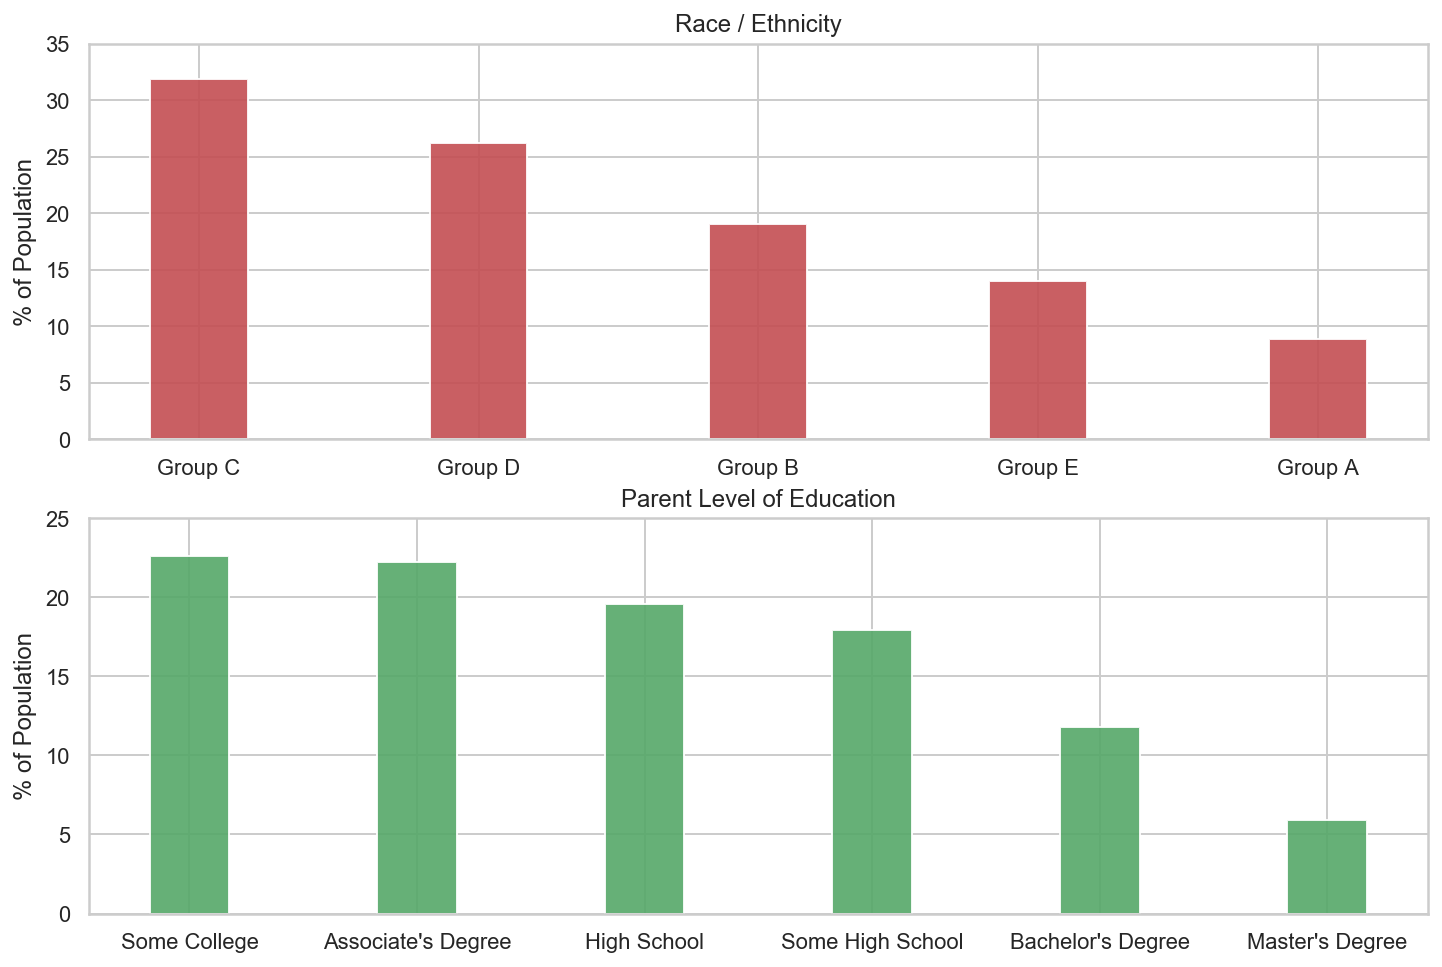

In [9]:
f, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_vc_bar_charts(df, 'race/ethnicity', ax=ax[0], color='r')
plot_vc_bar_charts(df, 'parental level of education', ax=ax[1], color='g')
ax[0].set_title('Race / Ethnicity')
ax[1].set_title('Parent Level of Education');
ax[0].set_ylabel('% of Population');
ax[1].set_ylabel('% of Population');
ax[0].set_ylim([0, 35])
ax[1].set_ylim([0, 25]);
f.savefig('images/chapter_03_ethnicity_ple_eda.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_03_ethnicity_ple_eda.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [10]:
def get_stats(df, grade_col):
    df_grade = df.groupby([grade_col]).agg({'lunch': 'count'}).reset_index()
    df_grade = df_grade.rename(columns={'lunch': 'count'})
    df_grade['pc'] = df_grade['count'] / len(df) * 100
    
    df_gender = df.groupby(['gender', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_gender = df_gender.rename(columns={'lunch': 'count'})
    df_gender['pc'] = df_gender['count'] / len(df) * 100
    
    df_race = df.groupby(['race/ethnicity', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_race = df_race.rename(columns={'lunch': 'count'})
    df_race['pc'] = df_race['count'] / len(df) * 100
    
    df_parent = df.groupby(['parental level of education', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_parent = df_parent.rename(columns={'lunch': 'count'})
    df_parent['pc'] = df_parent['count'] / len(df) * 100
    
    df_lunch = df.groupby(['lunch', grade_col]).agg({'gender': 'count'}).reset_index()
    df_lunch = df_lunch.rename(columns={'gender': 'count'})
    df_lunch['pc'] = df_lunch['count'] / len(df) * 100
    
    df_test_prep = df.groupby(['test preparation course', grade_col]).agg({'gender': 'count'}).reset_index()
    df_test_prep = df_test_prep.rename(columns={'gender': 'count'})
    df_test_prep['pc'] = df_lunch['count'] / len(df) * 100
    
    return df_grade, df_gender, df_race, df_parent, df_lunch, df_test_prep

In [11]:
df_grade_math, df_gender_math, df_race_math, df_parent_math, df_lunch_math, df_test_prep_math = get_stats(df, 'math grade')
df_grade_reading, df_gender_reading, df_race_reading, df_parent_reading, df_lunch_reading, df_test_prep_reading = get_stats(df, 'reading grade')
df_grade_writing, df_gender_writing, df_race_writing, df_parent_writing, df_lunch_writing, df_test_prep_writing = get_stats(df, 'writing grade')

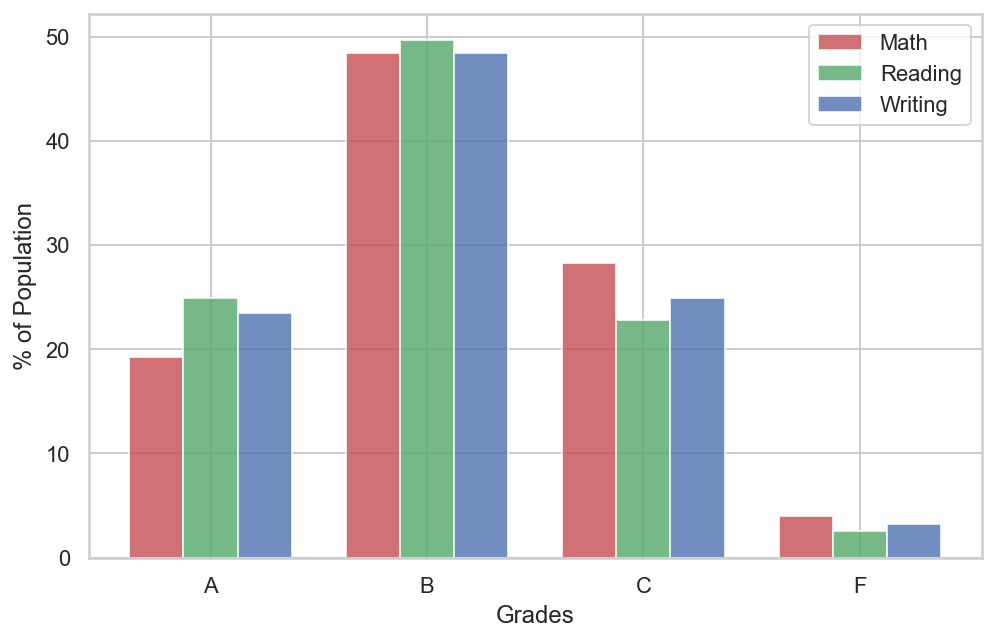

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.25

opacity = 0.8
error_config = {'ecolor': '0.3'}

ax.bar(index, df_grade_math['pc'], bar_width,
                alpha=opacity, color='r',
                label='Math')
ax.bar(index + bar_width, df_grade_reading['pc'], bar_width,
                alpha=opacity, color='g',
                label='Reading')
ax.bar(index + bar_width * 2, df_grade_writing['pc'], bar_width,
                alpha=opacity, color='b',
                label='Writing')

ax.set_xlabel('Grades')
ax.set_ylabel('% of Population')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(grades)
ax.legend()
ax.grid(True);
fig.savefig('images/chapter_03_grade_sub_eda.png', dpi=300, bbox_inches='tight');
fig.savefig('images/chapter_03_grade_sub_eda.pdf', format='pdf', dpi=300, bbox_inches='tight');

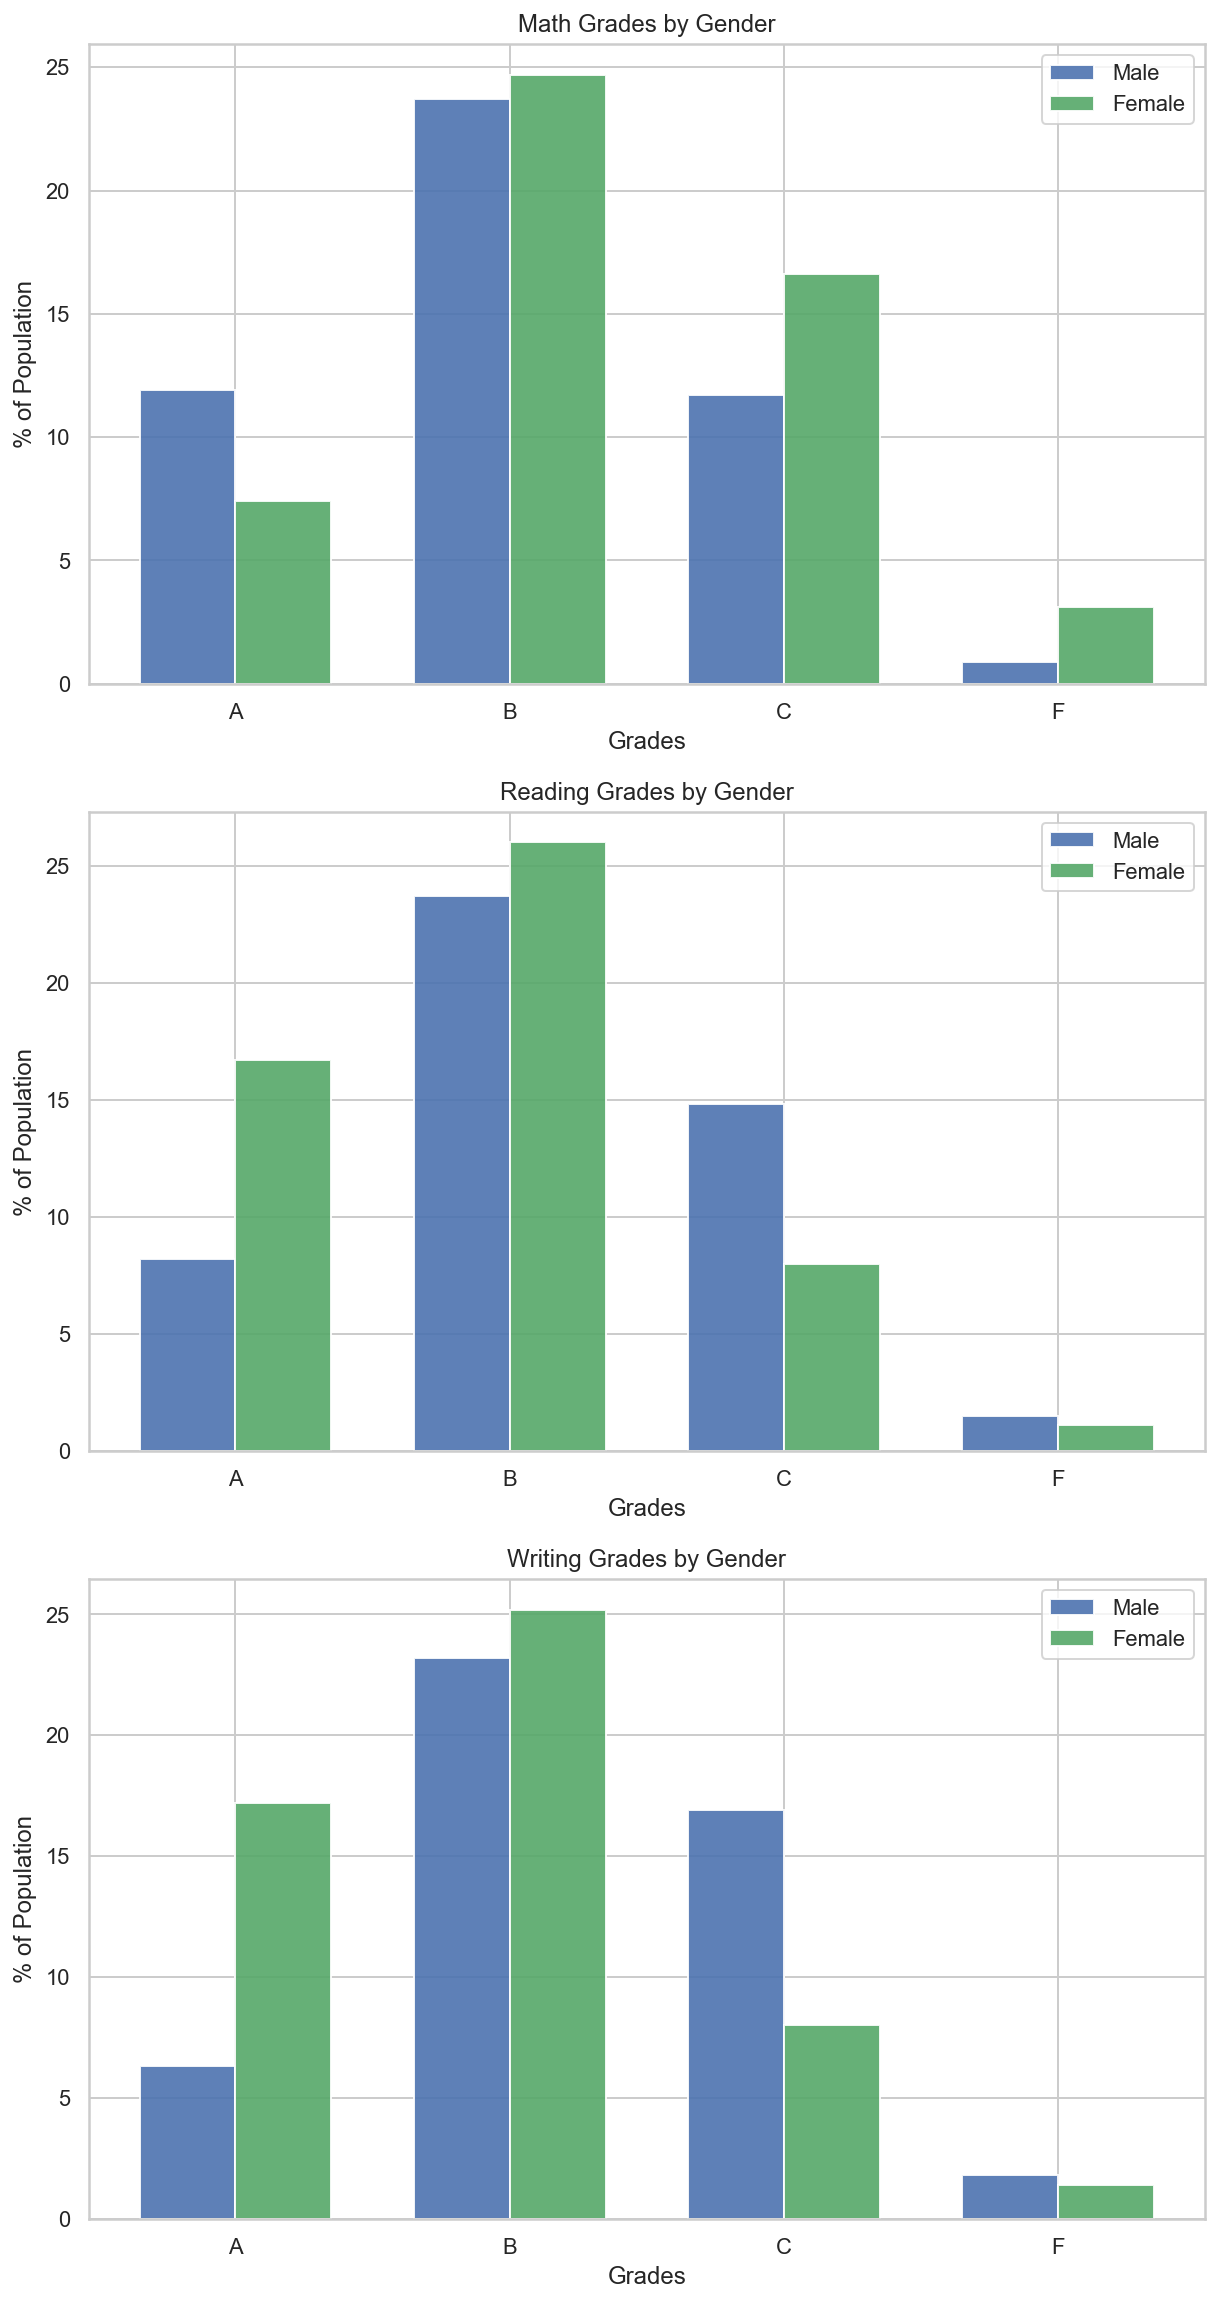

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20))

grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.35

opacity = 0.9
error_config = {'ecolor': '0.3'}

ax[0].bar(index, df_gender_math[df_gender_math['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[0].bar(index + bar_width, df_gender_math[df_gender_math['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[0].set_xlabel('Grades')
ax[0].set_ylabel('% of Population')
ax[0].set_title('Math Grades by Gender')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(grades)
ax[0].legend()
ax[0].grid(True);

ax[1].bar(index, df_gender_reading[df_gender_reading['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[1].bar(index + bar_width, df_gender_reading[df_gender_reading['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[1].set_xlabel('Grades')
ax[1].set_ylabel('% of Population')
ax[1].set_title('Reading Grades by Gender')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(grades)
ax[1].legend()
ax[1].grid(True);

ax[2].bar(index, df_gender_writing[df_gender_writing['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[2].bar(index + bar_width, df_gender_writing[df_gender_writing['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[2].set_xlabel('Grades')
ax[2].set_ylabel('% of Population')
ax[2].set_title('Writing Grades by Gender')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(grades)
ax[2].legend()
ax[2].grid(True);
fig.savefig('images/chapter_03_grades_by_gender.png', dpi=200, bbox_inches='tight');
fig.savefig('images/chapter_03_grades_by_gender.svg', format='svg', dpi=200, bbox_inches='tight');

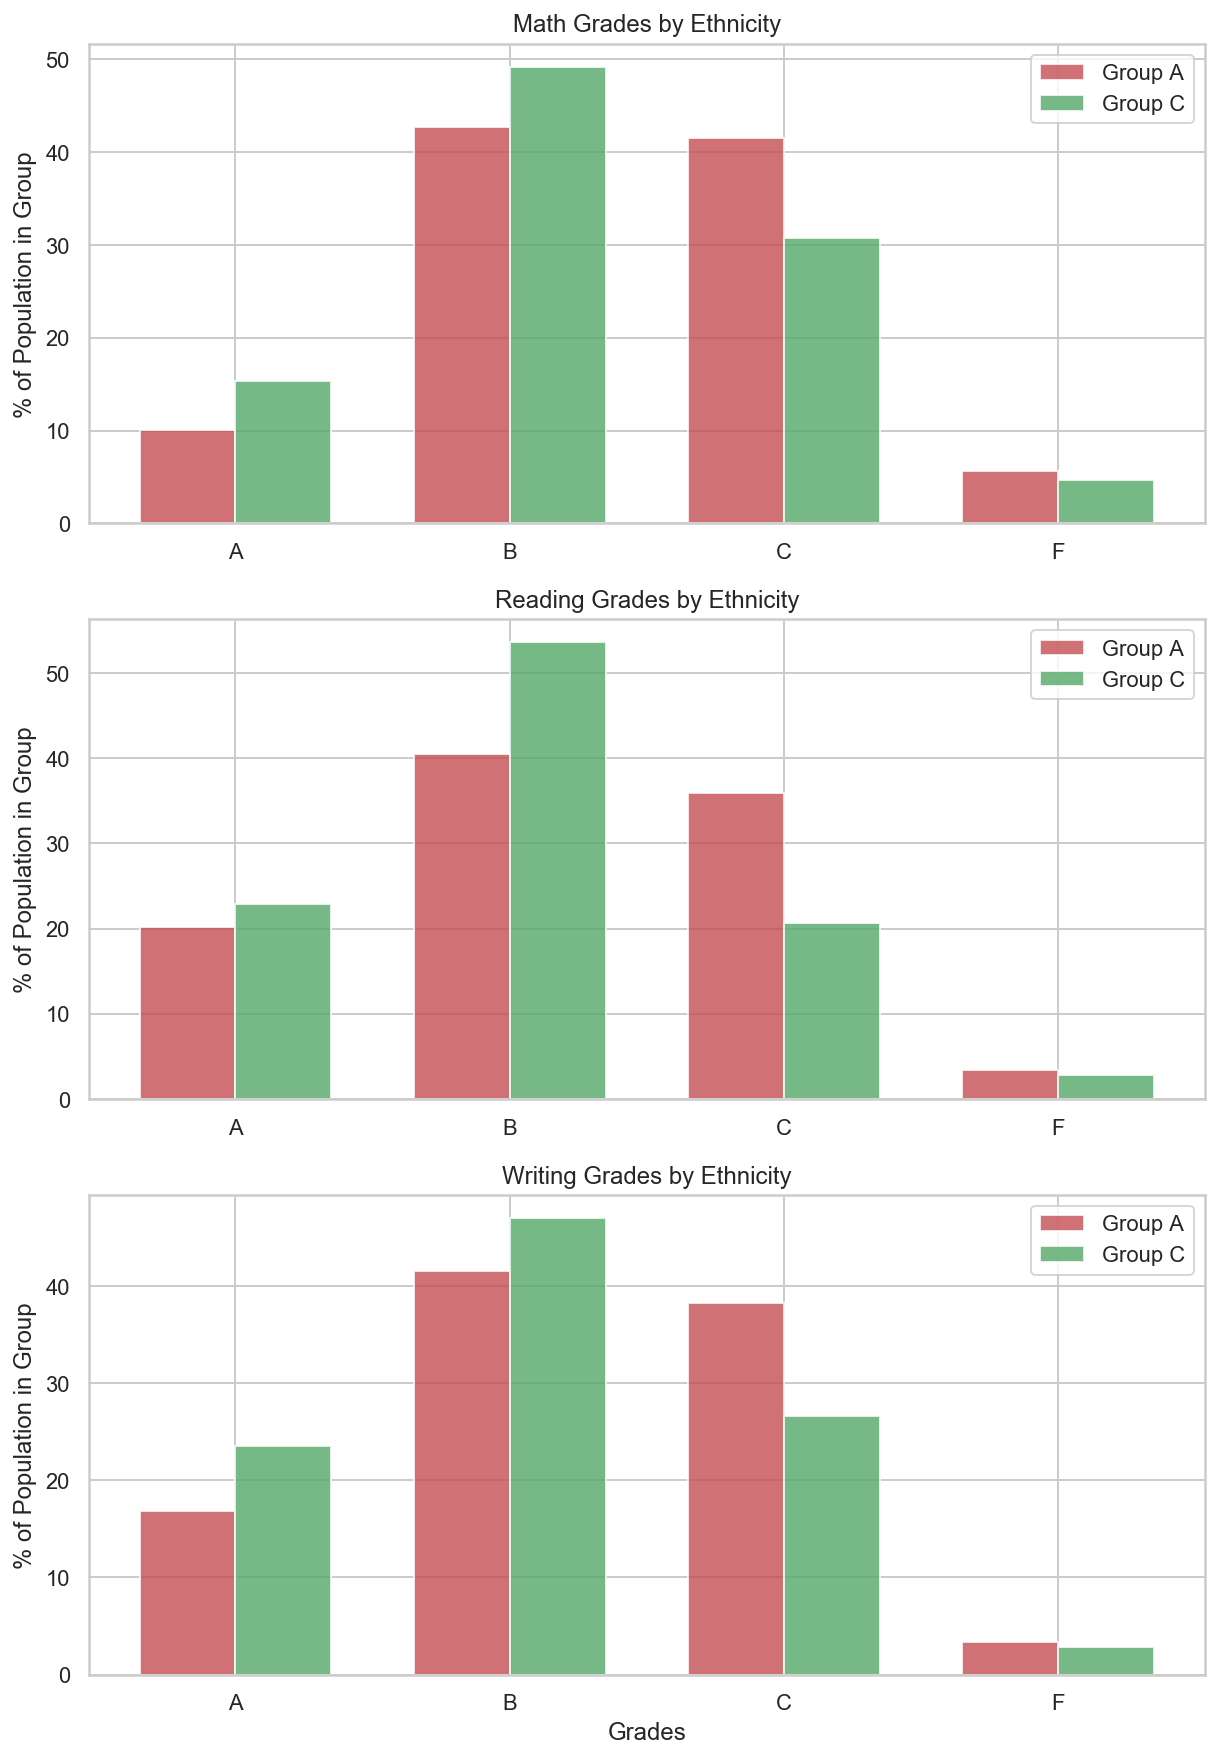

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

math_a_sum = df_race_math[df_race_math['race/ethnicity'] == 'group A']['pc'].sum()
math_c_sum = df_race_math[df_race_math['race/ethnicity'] == 'group C']['pc'].sum()
ax[0].bar(index, df_race_math[df_race_math['race/ethnicity'] == 'group A']['pc'] / math_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[0].bar(index + bar_width, df_race_math[df_race_math['race/ethnicity'] == 'group C']['pc'] / math_c_sum * 100, bar_width,
                alpha=opacity, color='g',
                label='Group C')

ax[0].set_xlabel('')
ax[0].set_ylabel('% of Population in Group')
ax[0].set_title('Math Grades by Ethnicity')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(grades)
ax[0].legend()
#     ax[0].set_ylim([0, 16])
ax[0].grid(True);

read_a_sum = df_race_reading[df_race_reading['race/ethnicity'] == 'group A']['pc'].sum()
read_c_sum = df_race_reading[df_race_reading['race/ethnicity'] == 'group C']['pc'].sum()
ax[1].bar(index, df_race_reading[df_race_reading['race/ethnicity'] == 'group A']['pc'] / read_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[1].bar(index + bar_width, df_race_reading[df_race_reading['race/ethnicity'] == 'group C']['pc'] / read_c_sum * 100, bar_width,
                alpha=opacity, color='g',
                label='Group C')

ax[1].set_xlabel('')
ax[1].set_ylabel('% of Population in Group')
ax[1].set_title('Reading Grades by Ethnicity')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(grades)
ax[1].legend()
#     ax[1].set_ylim([0, 18])
ax[1].grid(True);

write_a_sum = df_race_writing[df_race_writing['race/ethnicity'] == 'group A']['pc'].sum()
write_c_sum = df_race_writing[df_race_writing['race/ethnicity'] == 'group C']['pc'].sum()
ax[2].bar(index, df_race_writing[df_race_writing['race/ethnicity'] == 'group A']['pc'] / write_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[2].bar(index + bar_width, df_race_writing[df_race_writing['race/ethnicity'] == 'group C']['pc'] / write_c_sum * 100, bar_width,
                alpha=opacity, color='g',
                label='Group C')

ax[2].set_xlabel('Grades')
ax[2].set_ylabel('% of Population in Group')
ax[2].set_title('Writing Grades by Ethnicity')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(grades)
ax[2].legend()
#     ax[2].set_ylim([0, 16])
ax[2].grid(True);
fig.savefig('images/chapter_03_grades_by_race.png', dpi=300, bbox_inches='tight');
fig.savefig('images/chapter_03_grades_by_race.pdf', format='pdf', dpi=300, bbox_inches='tight');

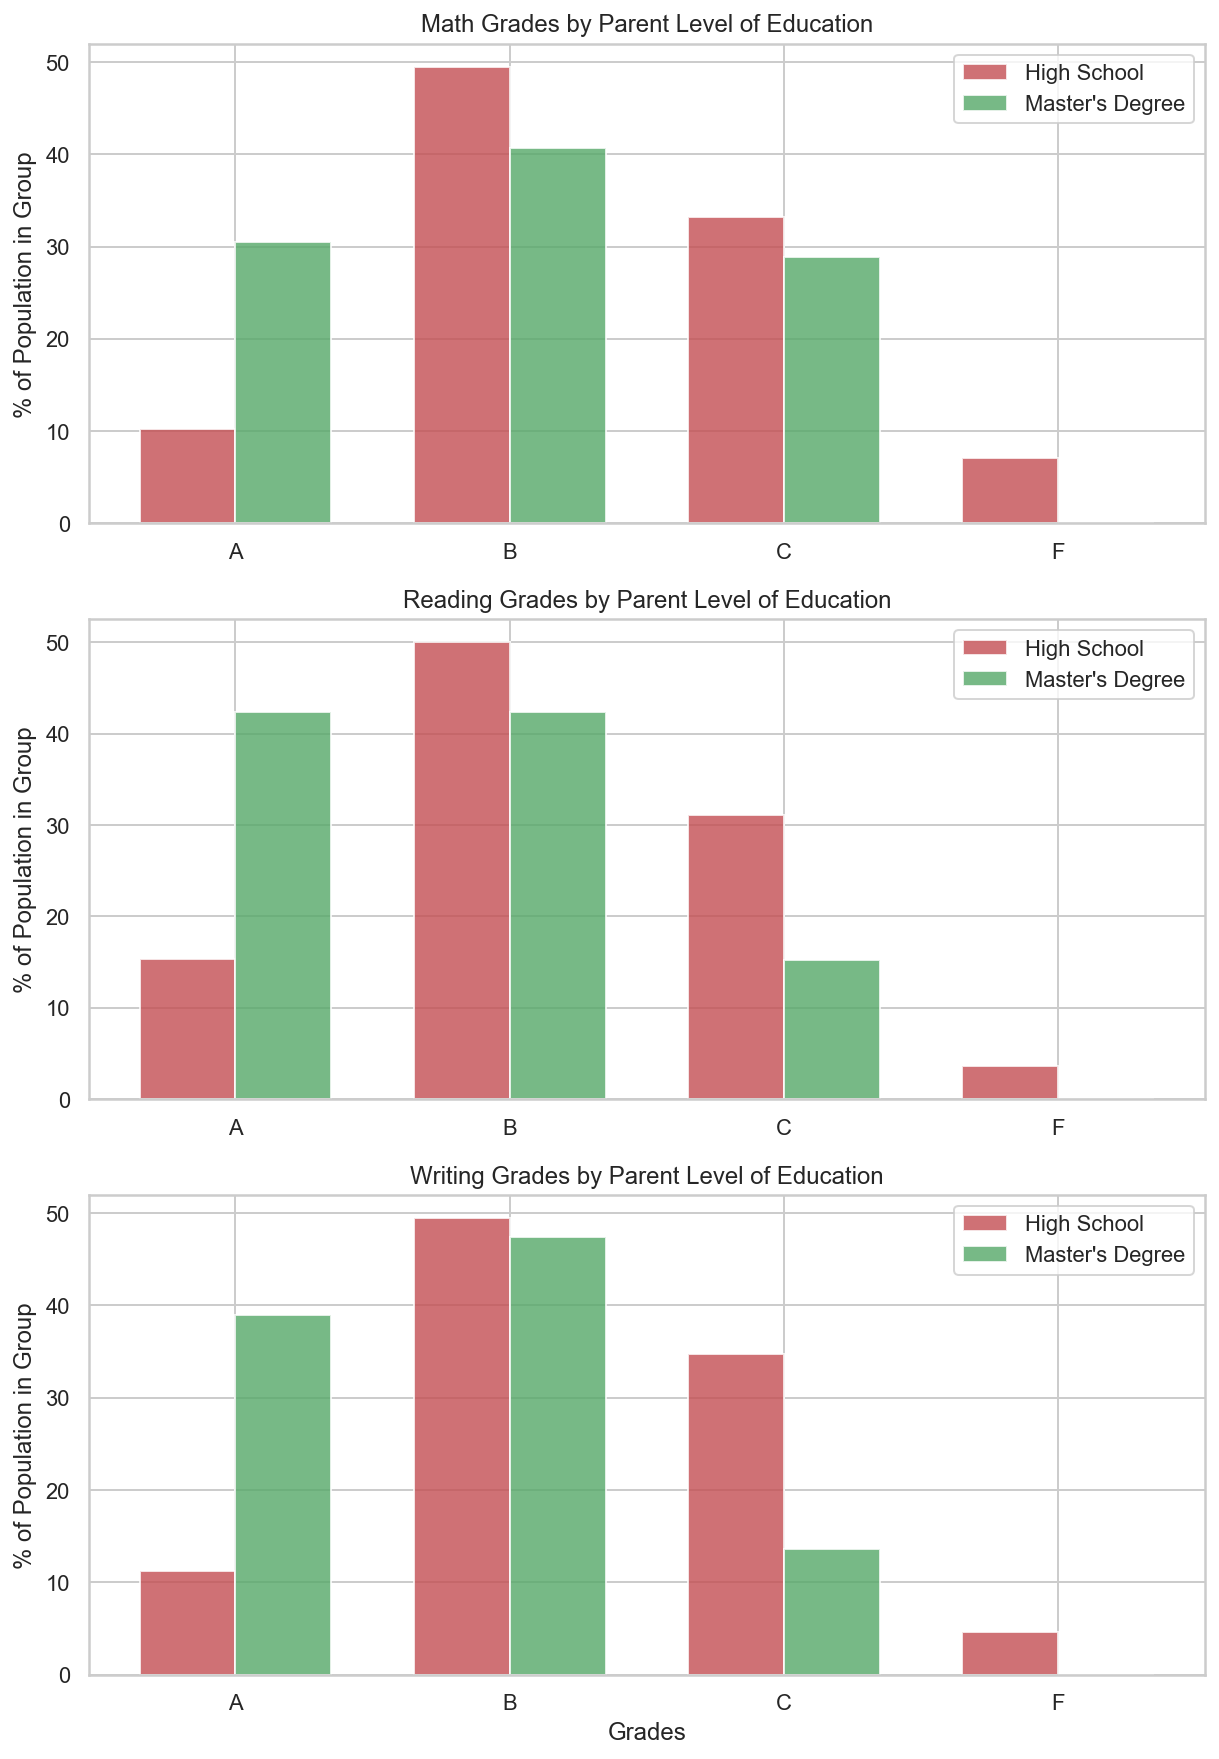

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

math_a_sum = df_parent_math[df_parent_math['parental level of education'] == 'high school']['pc'].sum()
math_c_sum = df_parent_math[df_parent_math['parental level of education'] == 'master\'s degree']['pc'].sum()
math_ma_pc = np.array(df_parent_math[df_parent_math['parental level of education'] == 'master\'s degree']['pc'].values) / math_c_sum * 100
math_ma_pc = np.append(math_ma_pc, 0) # for grade f
ax[0].bar(index, df_parent_math[df_parent_math['parental level of education'] == 'high school']['pc'] / math_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='High School')
ax[0].bar(index + bar_width, 
          math_ma_pc, bar_width,
                alpha=opacity, color='g',
                label='Master\'s Degree')

ax[0].set_xlabel('')
ax[0].set_ylabel('% of Population in Group')
ax[0].set_title('Math Grades by Parent Level of Education')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(grades)
ax[0].legend()
#     ax[0].set_ylim([0, 16])
ax[0].grid(True);

read_a_sum = df_parent_reading[df_parent_reading['parental level of education'] == 'high school']['pc'].sum()
read_c_sum = df_parent_reading[df_parent_reading['parental level of education'] == 'master\'s degree']['pc'].sum()
read_ma_pc = np.array(df_parent_reading[df_parent_reading['parental level of education'] == 'master\'s degree']['pc'].values) / read_c_sum * 100
read_ma_pc = np.append(read_ma_pc, 0) # for grade f
ax[1].bar(index, df_parent_reading[df_parent_reading['parental level of education'] == 'high school']['pc'] / read_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='High School')
ax[1].bar(index + bar_width, read_ma_pc, bar_width,
                alpha=opacity, color='g',
                label='Master\'s Degree')

ax[1].set_xlabel('')
ax[1].set_ylabel('% of Population in Group')
ax[1].set_title('Reading Grades by Parent Level of Education')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(grades)
ax[1].legend()
#     ax[1].set_ylim([0, 18])
ax[1].grid(True);

write_a_sum = df_parent_writing[df_parent_writing['parental level of education'] == 'high school']['pc'].sum()
write_c_sum = df_parent_writing[df_parent_writing['parental level of education'] == 'master\'s degree']['pc'].sum()
write_ma_pc = np.array(df_parent_writing[df_parent_writing['parental level of education'] == 'master\'s degree']['pc'].values) / write_c_sum * 100
write_ma_pc = np.append(write_ma_pc, 0) # for grade f
ax[2].bar(index, df_parent_writing[df_parent_writing['parental level of education'] == 'high school']['pc'] / write_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='High School')
ax[2].bar(index + bar_width, write_ma_pc, bar_width,
                alpha=opacity, color='g',
                label='Master\'s Degree')

ax[2].set_xlabel('Grades')
ax[2].set_ylabel('% of Population in Group')
ax[2].set_title('Writing Grades by Parent Level of Education')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(grades)
ax[2].legend()
#     ax[2].set_ylim([0, 16])
ax[2].grid(True);
fig.savefig('images/chapter_03_grades_by_ple.png', dpi=300, bbox_inches='tight');
fig.savefig('images/chapter_03_grades_by_ple.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Data Preparation

In [17]:
ple = ['high school', 'some high school', 'some college', "bachelor's degree", "associate's degree", "master's degree"]
ple_map = {}
for idx, p in enumerate(ple):
    ple_map[p] = idx

In [18]:
# First, encode the input features
gender_le = LabelEncoder()
race_le = LabelEncoder()
parent_le = LabelEncoder()
lunch_le = LabelEncoder()
test_prep_le = LabelEncoder()

gender_le.fit(df['gender'])
race_le.fit(df['race/ethnicity'])
parent_le.fit(df['parental level of education'])
lunch_le.fit(df['lunch'])
test_prep_le.fit(df['test preparation course'])

df['gender_le'] = gender_le.transform(df['gender'])
df['race_le'] = race_le.transform(df['race/ethnicity'])
df['parent_le'] = df['parental level of education'].apply(lambda x: ple_map[x])
df['lunch_le'] = lunch_le.transform(df['lunch'])
df['test_prep_le'] = test_prep_le.transform(df['test preparation course']);

In [19]:
# Next, encode the target variables
math_grade_le = LabelEncoder()
reading_grade_le = LabelEncoder()
writing_grade_le = LabelEncoder()

math_grade_le.fit(df['math grade'])
reading_grade_le.fit(df['reading grade'])
writing_grade_le.fit(df['writing grade'])

df['math_grade_le'] = math_grade_le.transform(df['math grade'])
df['reading_grade_le'] = reading_grade_le.transform(df['reading grade'])
df['writing_grade_le'] = writing_grade_le.transform(df['writing grade'])

In [20]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math grade,reading grade,writing grade,gender_le,race_le,parent_le,lunch_le,test_prep_le,math_grade_le,reading_grade_le,writing_grade_le
0,female,group B,bachelor's degree,standard,none,72,72,74,B,B,B,0,1,3,1,1,1,1,1
1,female,group C,some college,standard,completed,69,90,88,B,A,A,0,2,2,1,0,1,0,0
2,female,group B,master's degree,standard,none,90,95,93,A,A,A,0,1,5,1,1,0,0,0
3,male,group A,associate's degree,free/reduced,none,47,57,44,C,C,C,1,0,4,0,1,2,2,2
4,male,group C,some college,standard,none,76,78,75,B,B,B,1,2,2,1,1,1,1,1


In [21]:
df_train_val, df_test = train_test_split(df, test_size=0.2, stratify=df['math_grade_le'], 
                                         shuffle=True, random_state=42)
df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [22]:
feature_cols = ['gender_le', 'race_le', 'parent_le', 'lunch_le', 'test_prep_le']

X_train_val = df_train_val[feature_cols]
X_test = df_test[feature_cols]
y_math_train_val = df_train_val['math_grade_le']
y_reading_train_val = df_train_val['reading_grade_le']
y_writing_train_val = df_train_val['writing_grade_le']
y_math_test = df_test['math_grade_le']
y_reading_test = df_test['reading_grade_le']
y_writing_test = df_test['writing_grade_le']

# Train Models

In [23]:
def create_random_forest_model(n_estimators, 
                               max_depth=10,
                               criterion='gini',
                               random_state=42,
                               n_jobs=4):
    return RandomForestClassifier(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  criterion=criterion,
                                  random_state=random_state,
                                  n_jobs=n_jobs)

## Math Grade Model

In [24]:
math_model = create_random_forest_model(50)
math_model.fit(X_train_val, y_math_train_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [25]:
y_math_model_test = math_model.predict(X_test)
y_math_model_proba_test = math_model.predict_proba(X_test)

In [26]:
y_math_baseline = [1 for _ in range(len(y_math_model_proba_test))]

In [27]:
acc = math_model.score(X_test, y_math_test)
print(acc)

0.405


In [28]:
from sklearn.metrics import recall_score, precision_score, f1_score

precision = precision_score(y_math_test, y_math_model_test, average="weighted")
p_baseline = precision_score(y_math_test, y_math_baseline, average="weighted")
r_baseline = recall_score(y_math_test, y_math_baseline, average="weighted")
recall = recall_score(y_math_test, y_math_model_test, average="weighted")
f1 = f1_score(y_math_test, y_math_model_test, average="weighted")
f1_baseline = f1_score(y_math_test, y_math_baseline, average="weighted")
print(precision)
print(p_baseline)
print(recall)
print(r_baseline)
print(f1)
print(f1_baseline)

0.3944497863247863
0.23522500000000002
0.405
0.485
0.38839624410394635
0.3168013468013468


In [29]:
dump(math_model, 'models/math_model.joblib')

['models/math_model.joblib']

## Reading Grade Model

In [30]:
reading_model = create_random_forest_model(25)
reading_model.fit(X_train_val, y_reading_train_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=4,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [31]:
y_reading_model_test = reading_model.predict(X_test)
y_reading_model_proba_test = reading_model.predict_proba(X_test)

In [32]:
y_reading_baseline = [1 for _ in range(len(y_reading_model_test))]

In [33]:
acc = reading_model.score(X_test, y_reading_test)
print(acc)

0.435


In [34]:
from sklearn.metrics import recall_score, precision_score, f1_score

precision = precision_score(y_reading_test, y_reading_model_test, average="weighted")
p_baseline = precision_score(y_reading_test, y_reading_baseline, average="weighted")
r_baseline = recall_score(y_reading_test, y_reading_baseline, average="weighted")
recall = recall_score(y_reading_test, y_reading_model_test, average="weighted")
f1 = f1_score(y_reading_test, y_reading_model_test, average="weighted")
f1_baseline = f1_score(y_reading_test, y_reading_baseline, average="weighted")
print(precision)
print(p_baseline)
print(recall)
print(r_baseline)
print(f1)
print(f1_baseline)

0.39815517241379306
0.24009999999999998
0.435
0.49
0.3964222052457346
0.3222818791946308


In [35]:
dump(reading_model, 'models/reading_model.joblib')

['models/reading_model.joblib']

## Writing Grade Model

In [36]:
writing_model = create_random_forest_model(40)
writing_model.fit(X_train_val, y_writing_train_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=4,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [37]:
y_writing_model_test = writing_model.predict(X_test)
y_writing_model_proba_test = writing_model.predict_proba(X_test)

In [38]:
y_writing_baseline = [1 for _ in range(len(y_writing_model_test))]

In [39]:
from sklearn.metrics import recall_score, precision_score, f1_score

precision = precision_score(y_writing_test, y_writing_model_test, average="weighted")
p_baseline = precision_score(y_writing_test, y_writing_baseline, average="weighted")
r_baseline = recall_score(y_writing_test, y_writing_baseline, average="weighted")
recall = recall_score(y_writing_test, y_writing_model_test, average="weighted")
f1 = f1_score(y_writing_test, y_writing_model_test, average="weighted")
f1_baseline = f1_score(y_writing_test, y_writing_baseline, average="weighted")
print(precision)
print(p_baseline)
print(recall)
print(r_baseline)
print(f1)
print(f1_baseline)

0.4486882411067194
0.180625
0.445
0.425
0.41338429284512607
0.2535087719298246


In [40]:
dump(writing_model, 'models/writing_model.joblib')

['models/writing_model.joblib']

# Model Interpretation

## Feature Importance

In [41]:
math_model = load('models/math_model.joblib')
reading_model = load('models/reading_model.joblib')
writing_model = load('models/writing_model.joblib')

In [42]:
feature_names = ['Gender', 'Ethnicity', 'Parent Level of Education', 
                 'Lunch', 'Test Preparation']
math_fi = math_model.feature_importances_ * 100
reading_fi = reading_model.feature_importances_ * 100
writing_fi = writing_model.feature_importances_ * 100

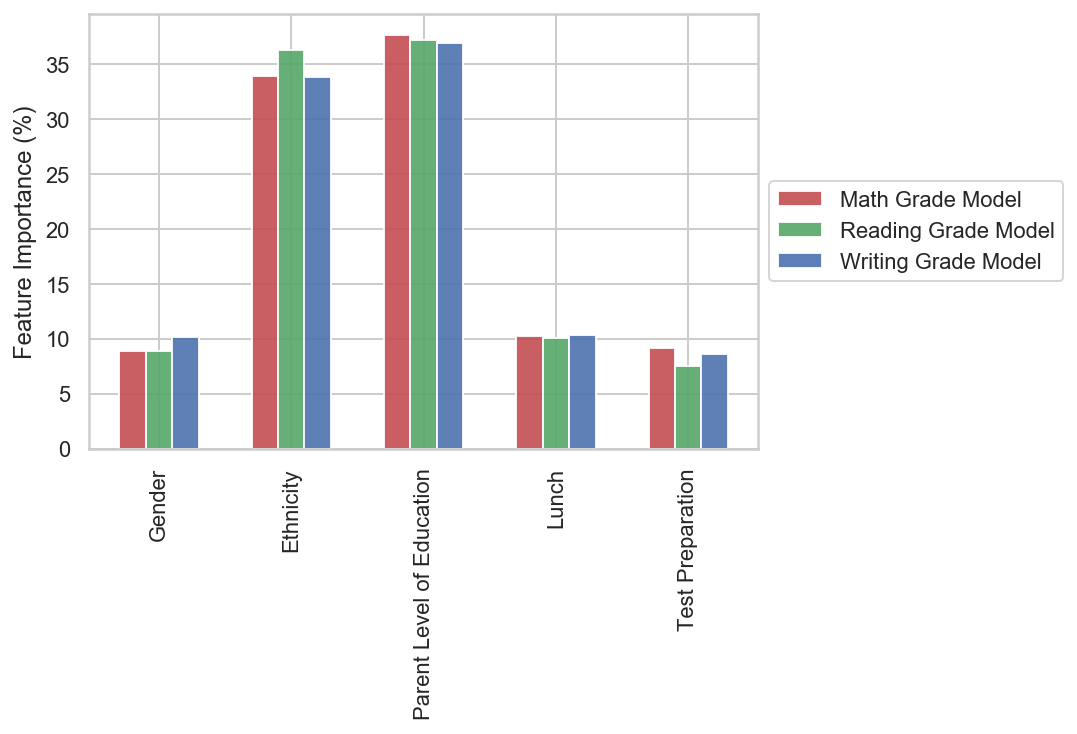

In [43]:
fig, ax = plt.subplots()
index = np.arange(len(feature_names))
bar_width = 0.2
opacity = 0.9
error_config = {'ecolor': '0.3'}
ax.bar(index, math_fi, bar_width,
       alpha=opacity, color='r',
       label='Math Grade Model')
ax.bar(index + bar_width, reading_fi, bar_width,
       alpha=opacity, color='g',
       label='Reading Grade Model')
ax.bar(index + bar_width * 2, writing_fi, bar_width,
       alpha=opacity, color='b',
       label='Writing Grade Model')   
ax.set_xlabel('')
ax.set_ylabel('Feature Importance (%)')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(feature_names)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True);
fig.savefig('images/chapter_03_math_reading_writing_feature_importances.png', dpi=300, bbox_inches='tight');
fig.savefig('images/chapter_03_math_reading_writing_feature_importances.pdf', format='pdf', dpi=300, bbox_inches='tight');

## Partial Dependence Plots

In [44]:
parent_codes = np.arange(0, 6)
parent_codes_decoded = [' '.join([x.capitalize() for x in p.split()]) for p in ple]
parent_title = str(dict(zip(parent_codes, parent_codes_decoded)))

race_codes = np.arange(0, 5)
race_codes_decoded = [' '.join([x.capitalize() for x in r.split()]) for r in race_le.inverse_transform(race_codes)]
race_title = str(dict(zip(race_codes, race_codes_decoded)))

In [45]:
parent_title = '{0: \'High School\', 1: \'Some High School\', 2: \'Some College\', 3: "Associate\'s Degree", 4: "Bachelor\'s Degree", 5: "Master\'s Degree"}'

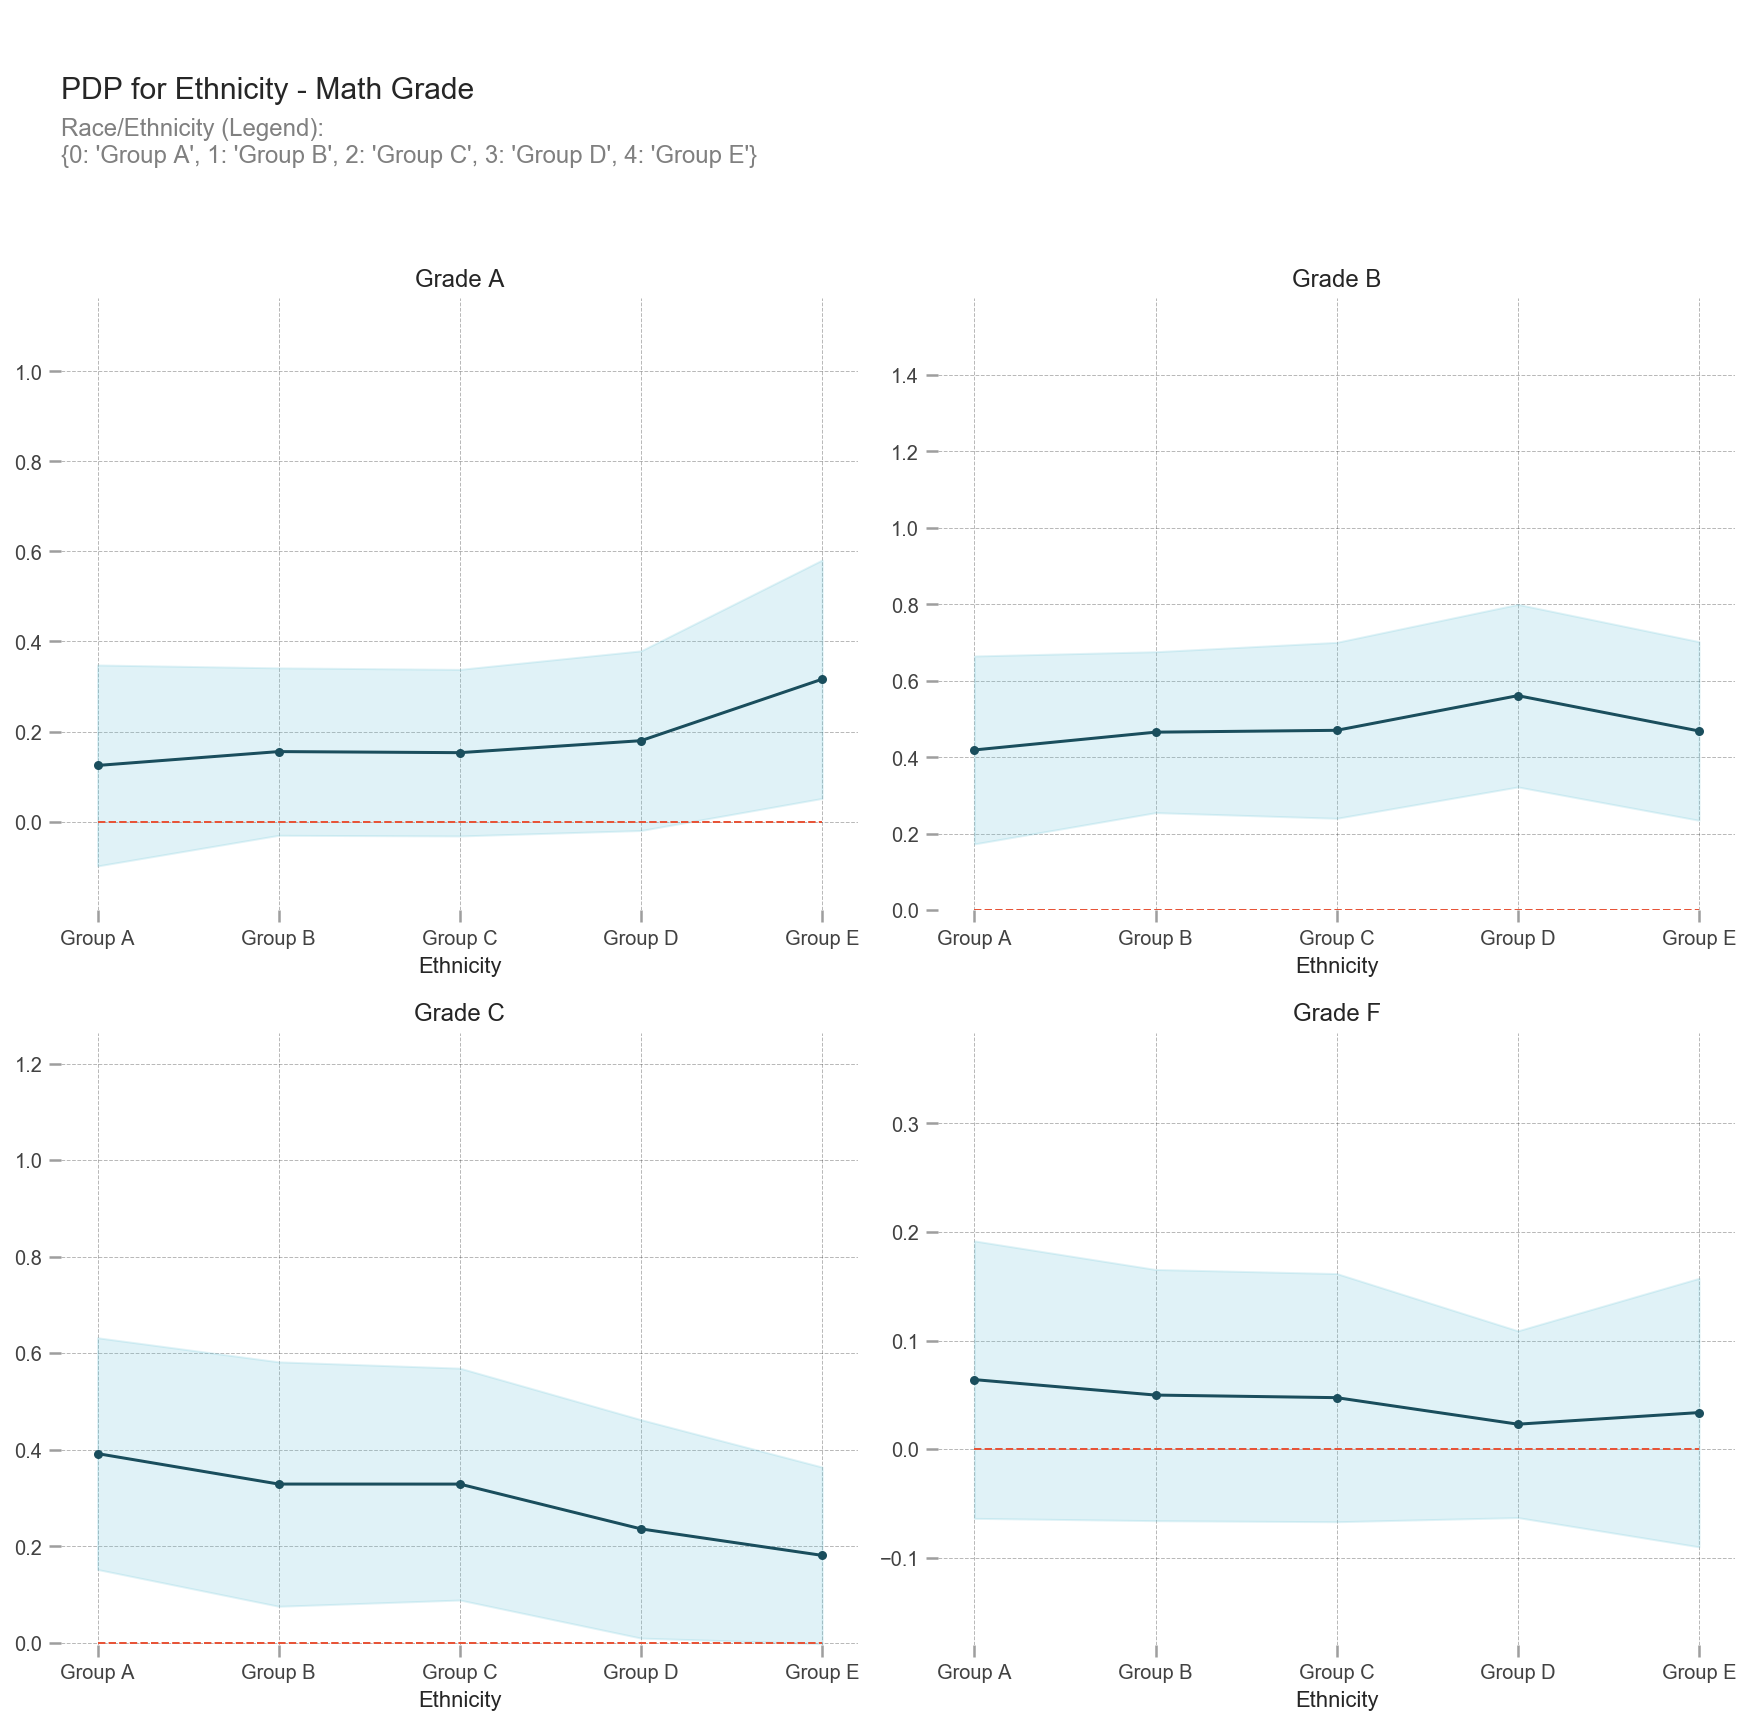

In [46]:
pdp_race = pdp.pdp_isolate(model=math_model,
                          dataset=df,
                          model_features=feature_cols,
                          feature='race_le')
ethnicity_xtick_labels = ['Group A', 'Group B', 'Group C',
                          'Group D', 'Group E']
plot_params = {
    # plot title and subtitle
    'title': 'PDP for Ethnicity - Math Grade',
    'subtitle': 'Race/Ethnicity (Legend): \n%s' % (race_title),
    'title_fontsize': 15,
    'subtitle_fontsize': 12,
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 0.8,
    # fontsize for interact plot text
    'inter_fontsize': 9,
}
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_race, feature_name='Race/Ethnicity', 
                         center=False, x_quantile=False, ncols=2, plot_lines=False, frac_to_plot=100,
                         plot_params=plot_params)
axes['pdp_ax'][0].set_xlabel('Ethnicity')
axes['pdp_ax'][1].set_xlabel('Ethnicity')
axes['pdp_ax'][2].set_xlabel('Ethnicity')
axes['pdp_ax'][3].set_xlabel('Ethnicity')
axes['pdp_ax'][0].set_title('Grade A')
axes['pdp_ax'][1].set_title('Grade B')
axes['pdp_ax'][2].set_title('Grade C')
axes['pdp_ax'][3].set_title('Grade F')
axes['pdp_ax'][0].set_xticks(race_codes)
axes['pdp_ax'][1].set_xticks(race_codes)
axes['pdp_ax'][2].set_xticks(race_codes)
axes['pdp_ax'][3].set_xticks(race_codes)
axes['pdp_ax'][0].set_xticklabels(ethnicity_xtick_labels)
axes['pdp_ax'][1].set_xticklabels(ethnicity_xtick_labels)
axes['pdp_ax'][2].set_xticklabels(ethnicity_xtick_labels)
axes['pdp_ax'][3].set_xticklabels(ethnicity_xtick_labels)
fig.savefig('images/chapter_03_pdp_race_math.png', dpi=300, bbox_inches='tight')
fig.savefig('images/chapter_03_pdp_race_math.pdf', format='pdf', dpi=300, bbox_inches='tight')

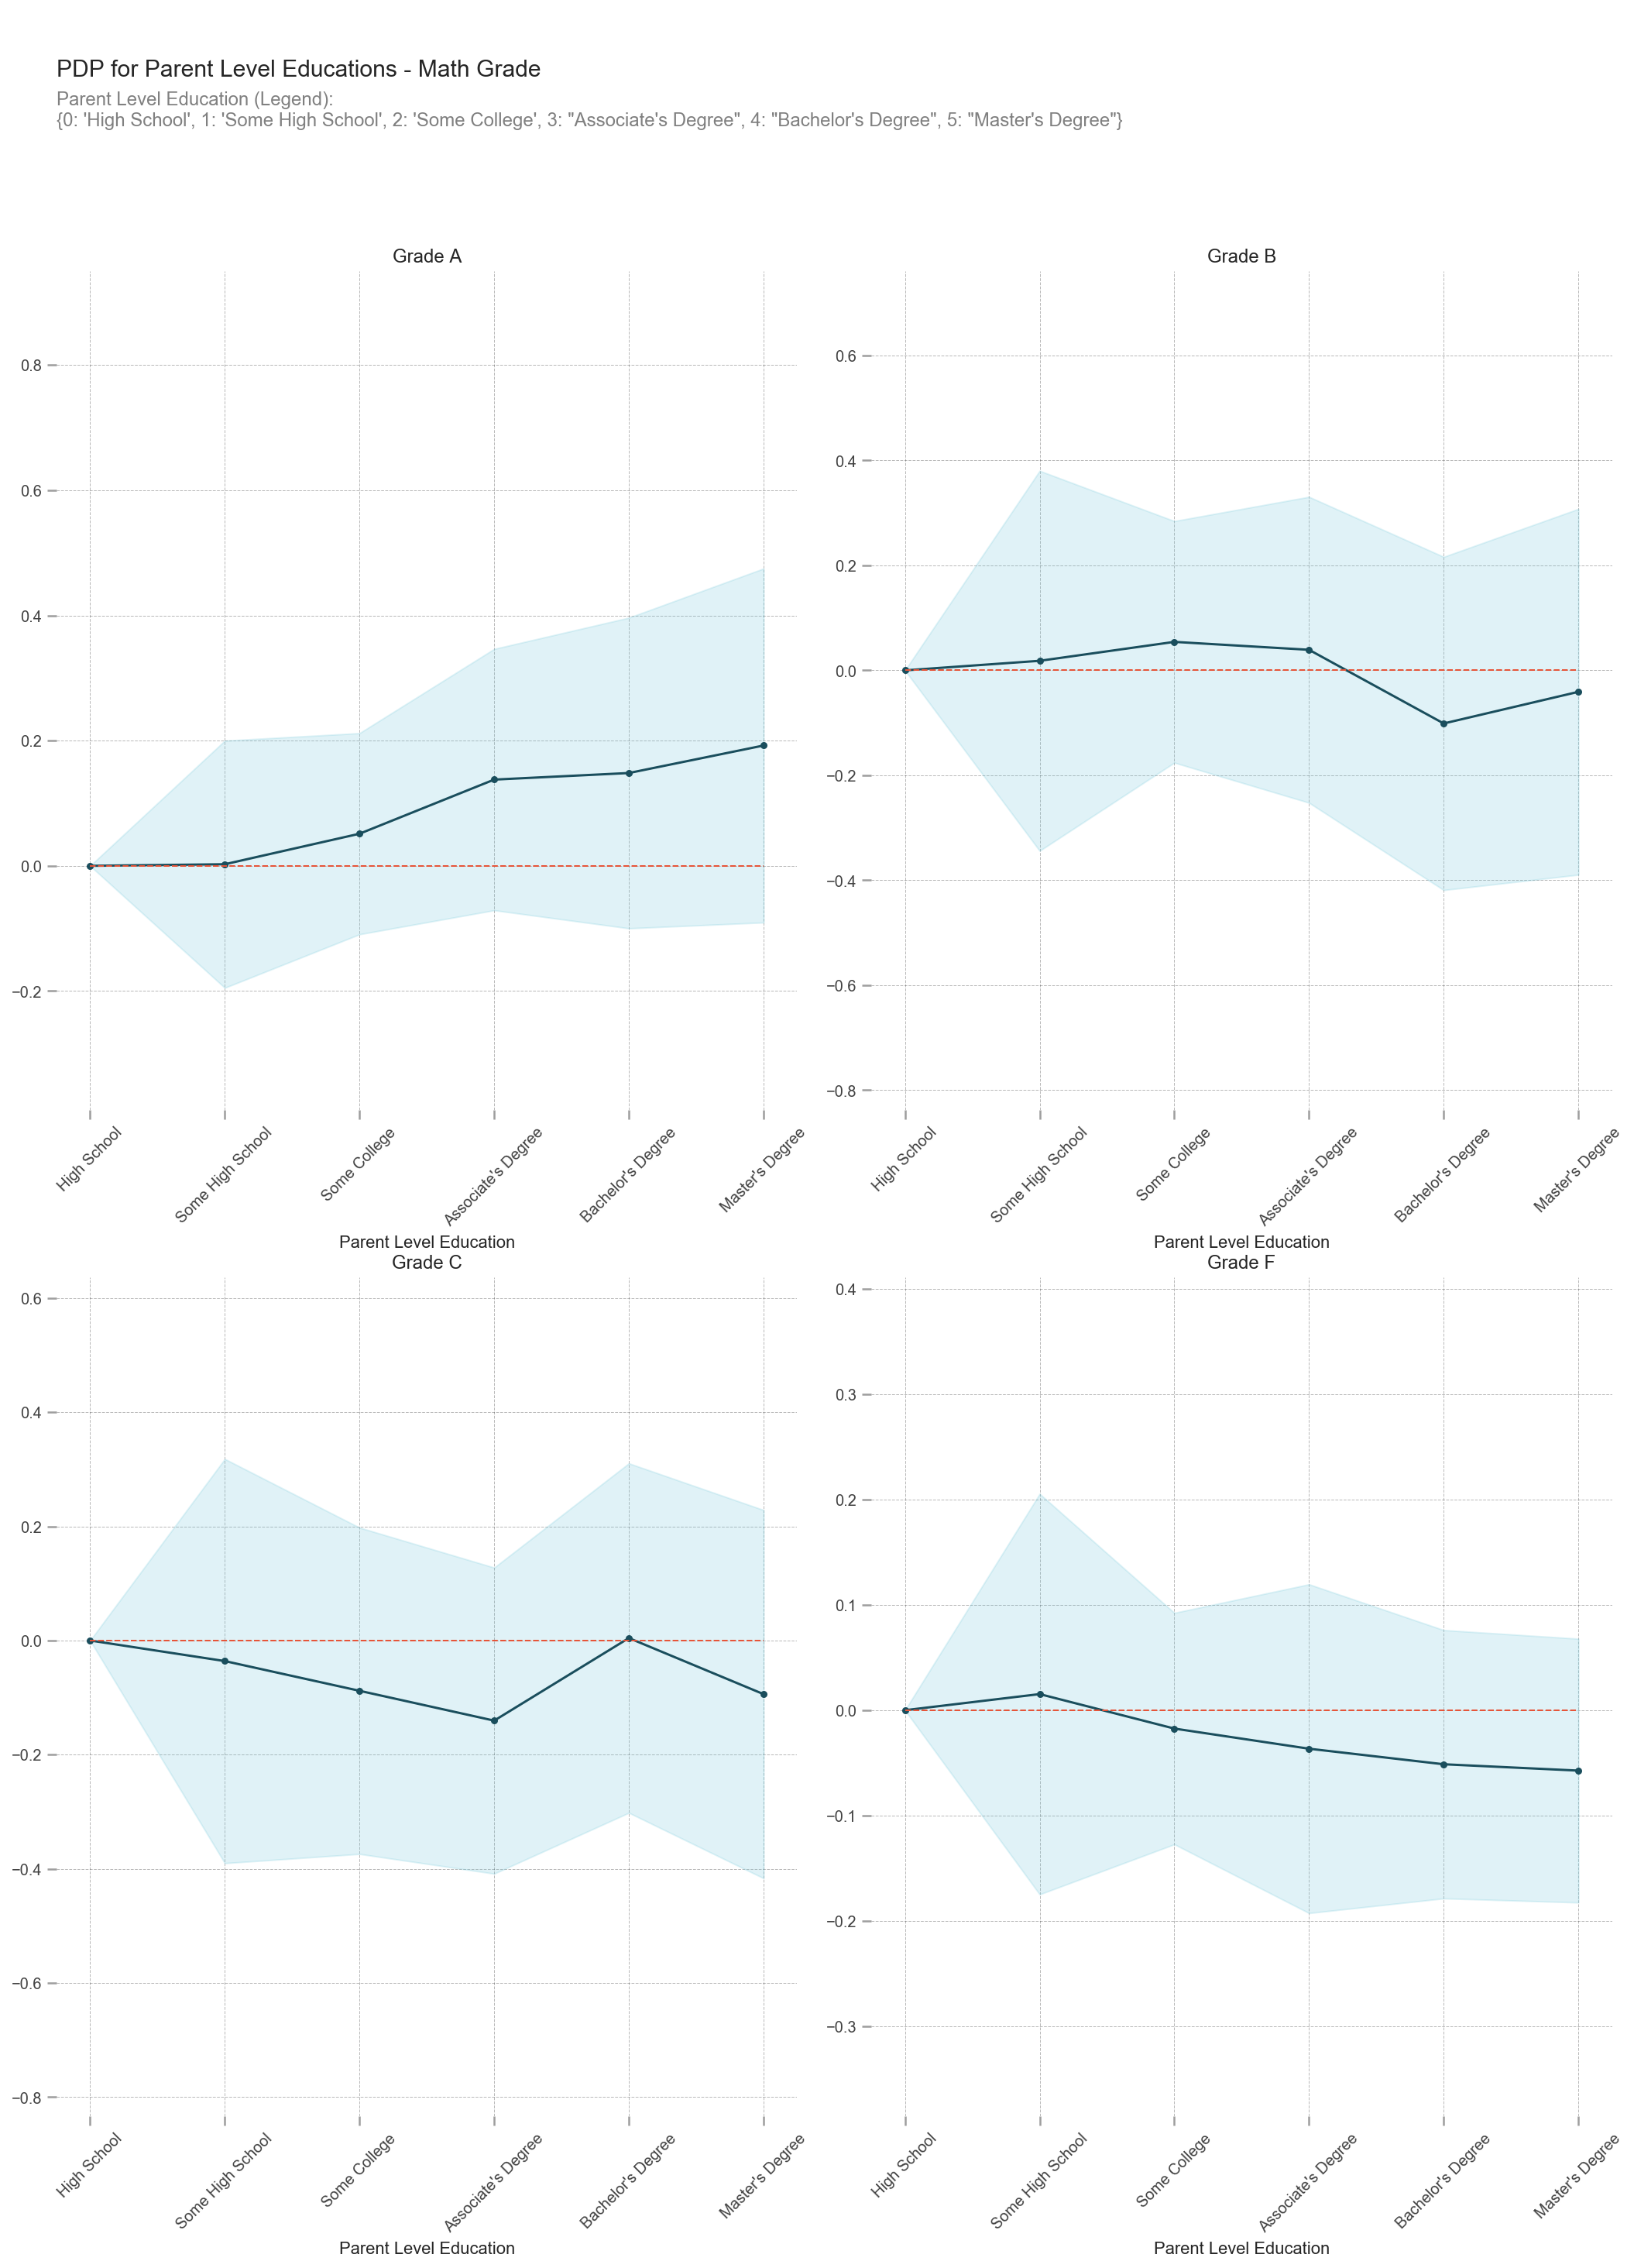

In [47]:
pdp_race = pdp.pdp_isolate(model=math_model,
                          dataset=df,
                          model_features=feature_cols,
                          feature='parent_le')
ple_xticklabels = ['High School',
                   'Some High School',
                   'Some College',
                   "Associate\'s Degree",
                   "Bachelor\'s Degree",
                   "Master\'s Degree"]
plot_params = {
    # plot title and subtitle
    'title': 'PDP for Parent Level Educations - Math Grade',
    'subtitle': 'Parent Level Education (Legend): \n%s' % (parent_title),
    'title_fontsize': 15,
    'subtitle_fontsize': 12,
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 0.8,
    # fontsize for interact plot text
    'inter_fontsize': 9,
}
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_race, feature_name='Parent Level Education', 
                         center=True, x_quantile=False, ncols=2, plot_lines=False, frac_to_plot=100,
                         plot_params=plot_params, figsize=(18, 25))
axes['pdp_ax'][0].set_xlabel('Parent Level Education')
axes['pdp_ax'][1].set_xlabel('Parent Level Education')
axes['pdp_ax'][2].set_xlabel('Parent Level Education')
axes['pdp_ax'][3].set_xlabel('Parent Level Education')
axes['pdp_ax'][0].set_title('Grade A')
axes['pdp_ax'][1].set_title('Grade B')
axes['pdp_ax'][2].set_title('Grade C')
axes['pdp_ax'][3].set_title('Grade F')
axes['pdp_ax'][0].set_xticks(parent_codes)
axes['pdp_ax'][1].set_xticks(parent_codes)
axes['pdp_ax'][2].set_xticks(parent_codes)
axes['pdp_ax'][3].set_xticks(parent_codes)
axes['pdp_ax'][0].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][1].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][2].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][3].set_xticklabels(ple_xticklabels)
for tick in axes['pdp_ax'][0].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][1].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][2].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][3].get_xticklabels():
    tick.set_rotation(45)
fig.savefig('images/chapter_03_pdp_parent_math.png', dpi=300, bbox_inches='tight')
fig.savefig('images/chapter_03_pdp_parent_math.pdf', format='pdf', dpi=300, bbox_inches='tight')

## ICE

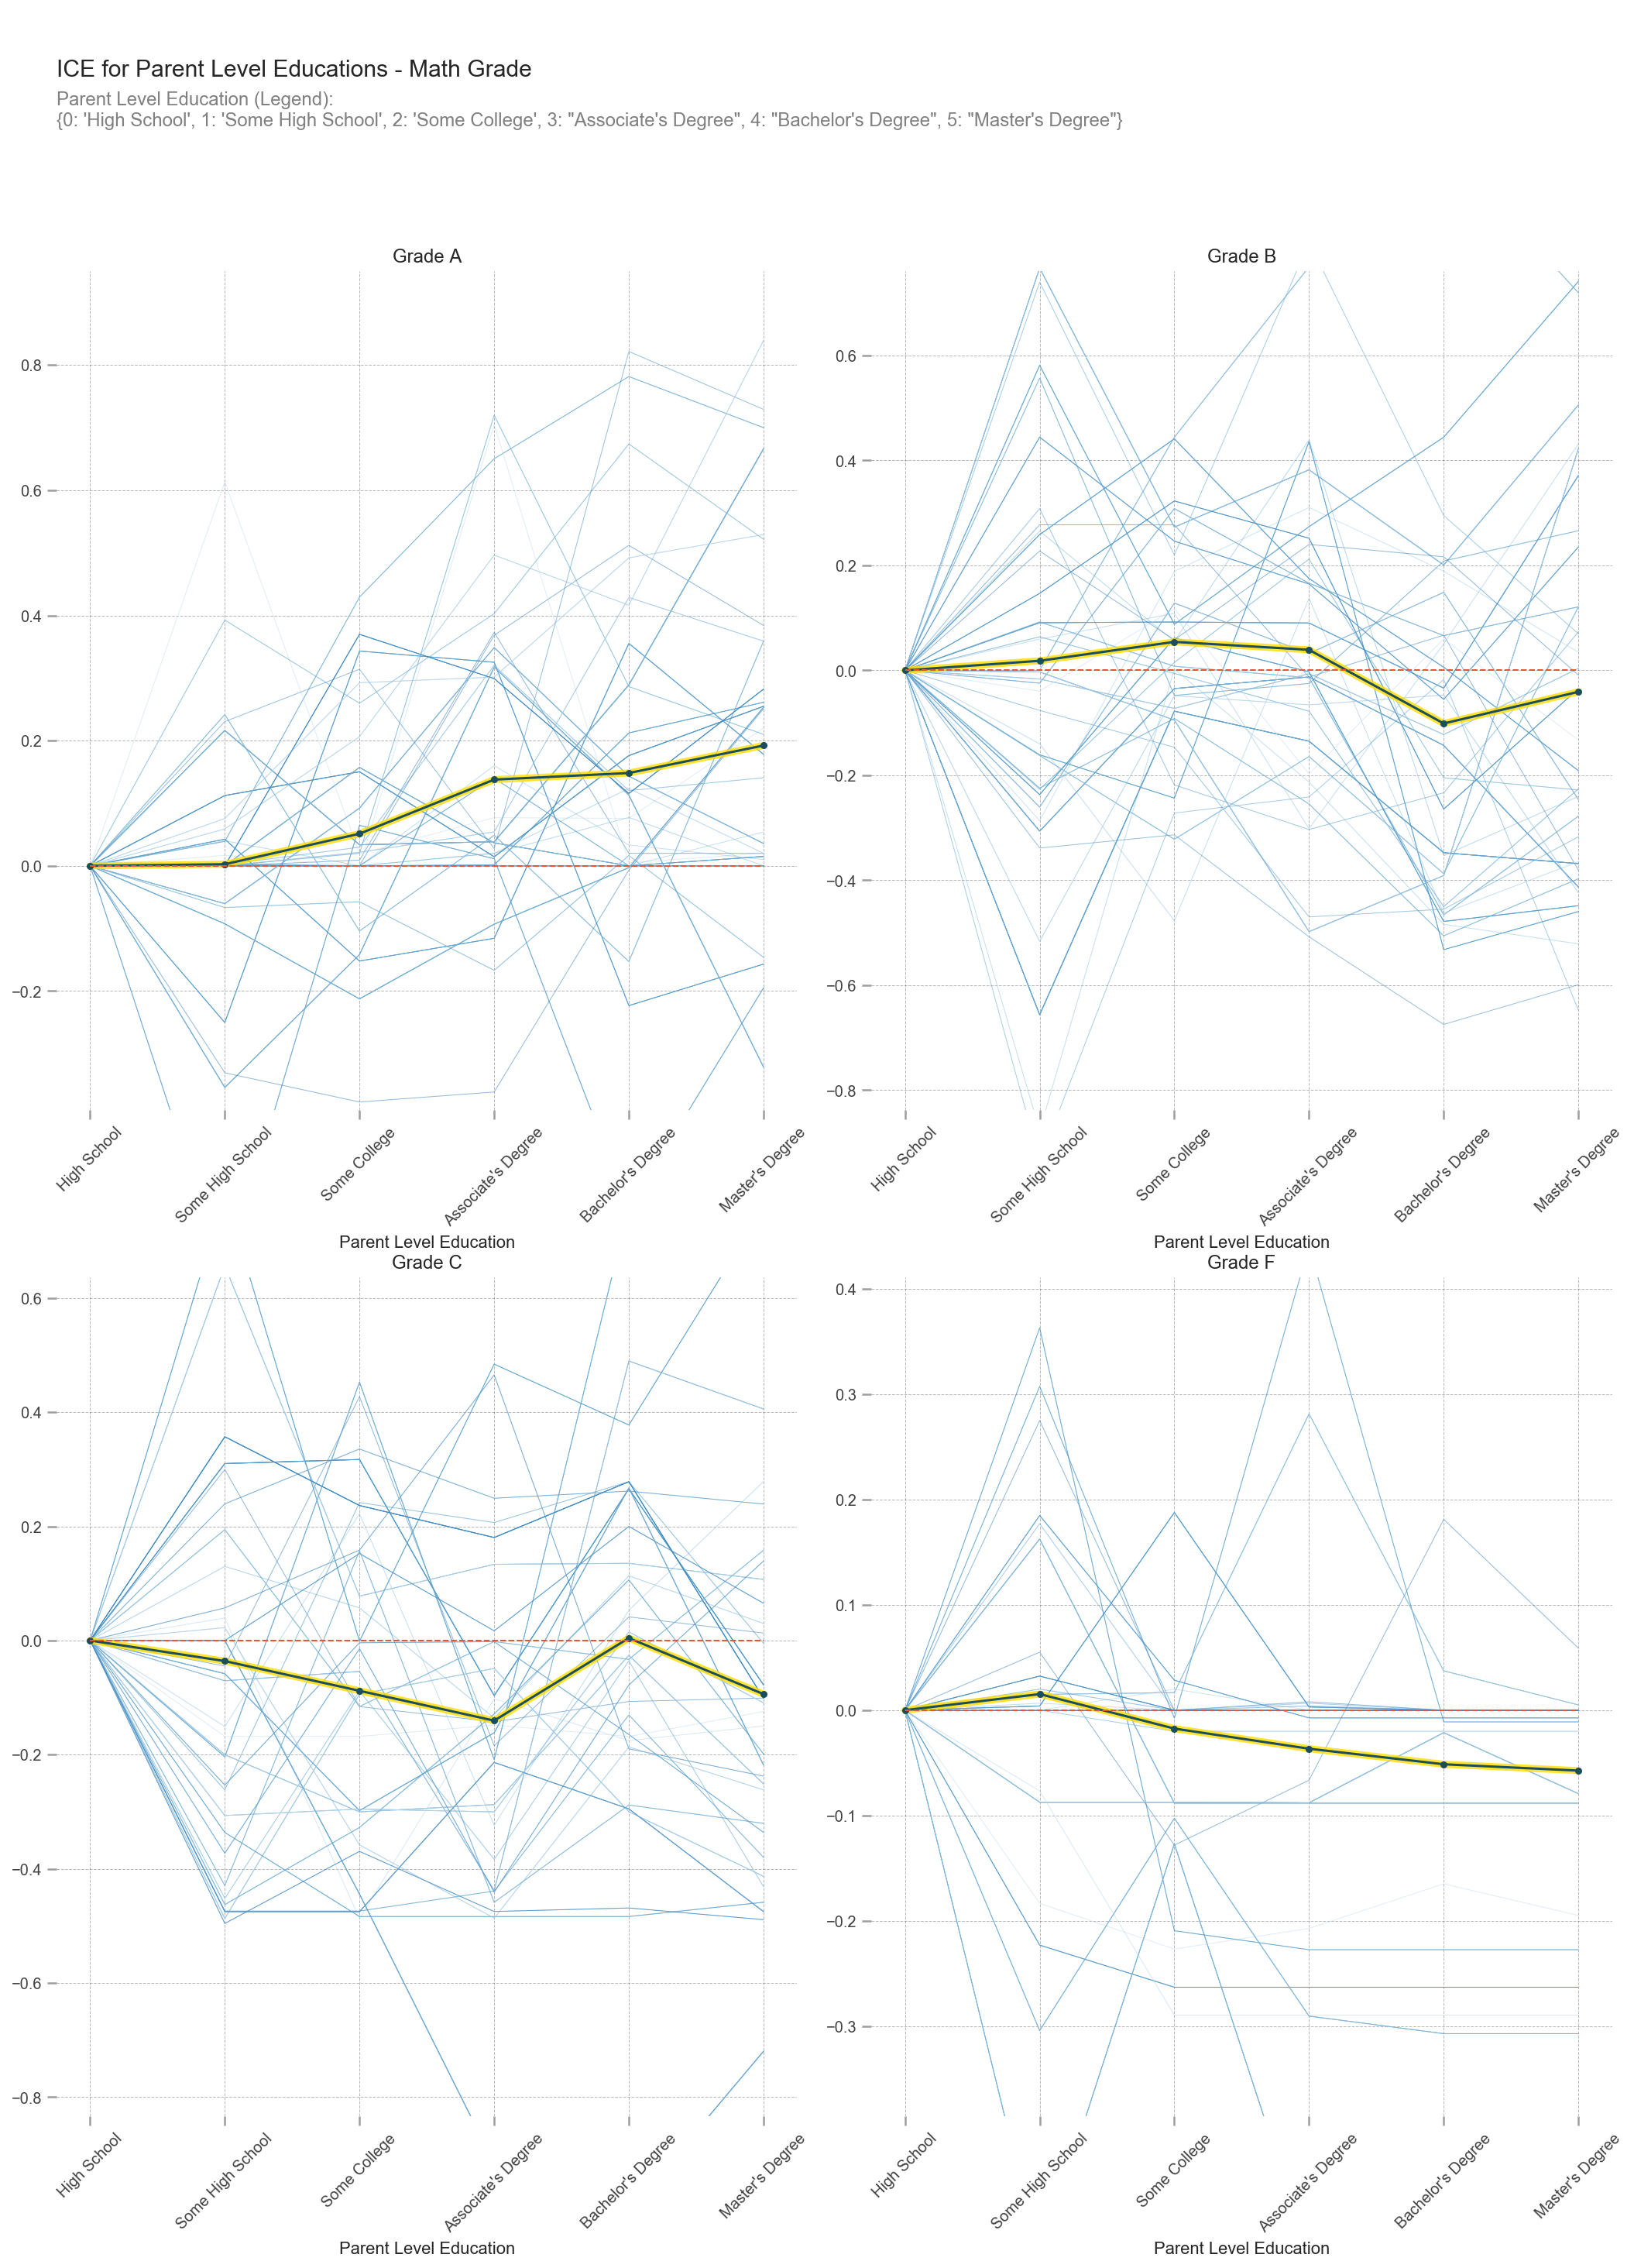

In [48]:
pdp_race = pdp.pdp_isolate(model=math_model,
                          dataset=df,
                          model_features=feature_cols,
                          feature='parent_le')
ple_xticklabels = ['High School',
                   'Some High School',
                   'Some College',
                   "Associate\'s Degree",
                   "Bachelor\'s Degree",
                   "Master\'s Degree"]
plot_params = {
    # plot title and subtitle
    'title': 'ICE for Parent Level Educations - Math Grade',
    'subtitle': 'Parent Level Education (Legend): \n%s' % (parent_title),
    'title_fontsize': 15,
    'subtitle_fontsize': 12,
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 0.8,
    # fontsize for interact plot text
    'inter_fontsize': 9,
}
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_race, feature_name='Parent Level Education', 
                         center=True, x_quantile=False, ncols=2, plot_lines=True, frac_to_plot=100,
                         plot_params=plot_params, figsize=(18, 25))
axes['pdp_ax'][0].set_xlabel('Parent Level Education')
axes['pdp_ax'][1].set_xlabel('Parent Level Education')
axes['pdp_ax'][2].set_xlabel('Parent Level Education')
axes['pdp_ax'][3].set_xlabel('Parent Level Education')
axes['pdp_ax'][0].set_title('Grade A')
axes['pdp_ax'][1].set_title('Grade B')
axes['pdp_ax'][2].set_title('Grade C')
axes['pdp_ax'][3].set_title('Grade F')
axes['pdp_ax'][0].set_xticks(parent_codes)
axes['pdp_ax'][1].set_xticks(parent_codes)
axes['pdp_ax'][2].set_xticks(parent_codes)
axes['pdp_ax'][3].set_xticks(parent_codes)
axes['pdp_ax'][0].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][1].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][2].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][3].set_xticklabels(ple_xticklabels)
for tick in axes['pdp_ax'][0].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][1].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][2].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][3].get_xticklabels():
    tick.set_rotation(45)
fig.savefig('images/chapter_03_ice_parent_math.png', dpi=300, bbox_inches='tight')
fig.savefig('images/chapter_03_ice_parent_math.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Feature Interactions

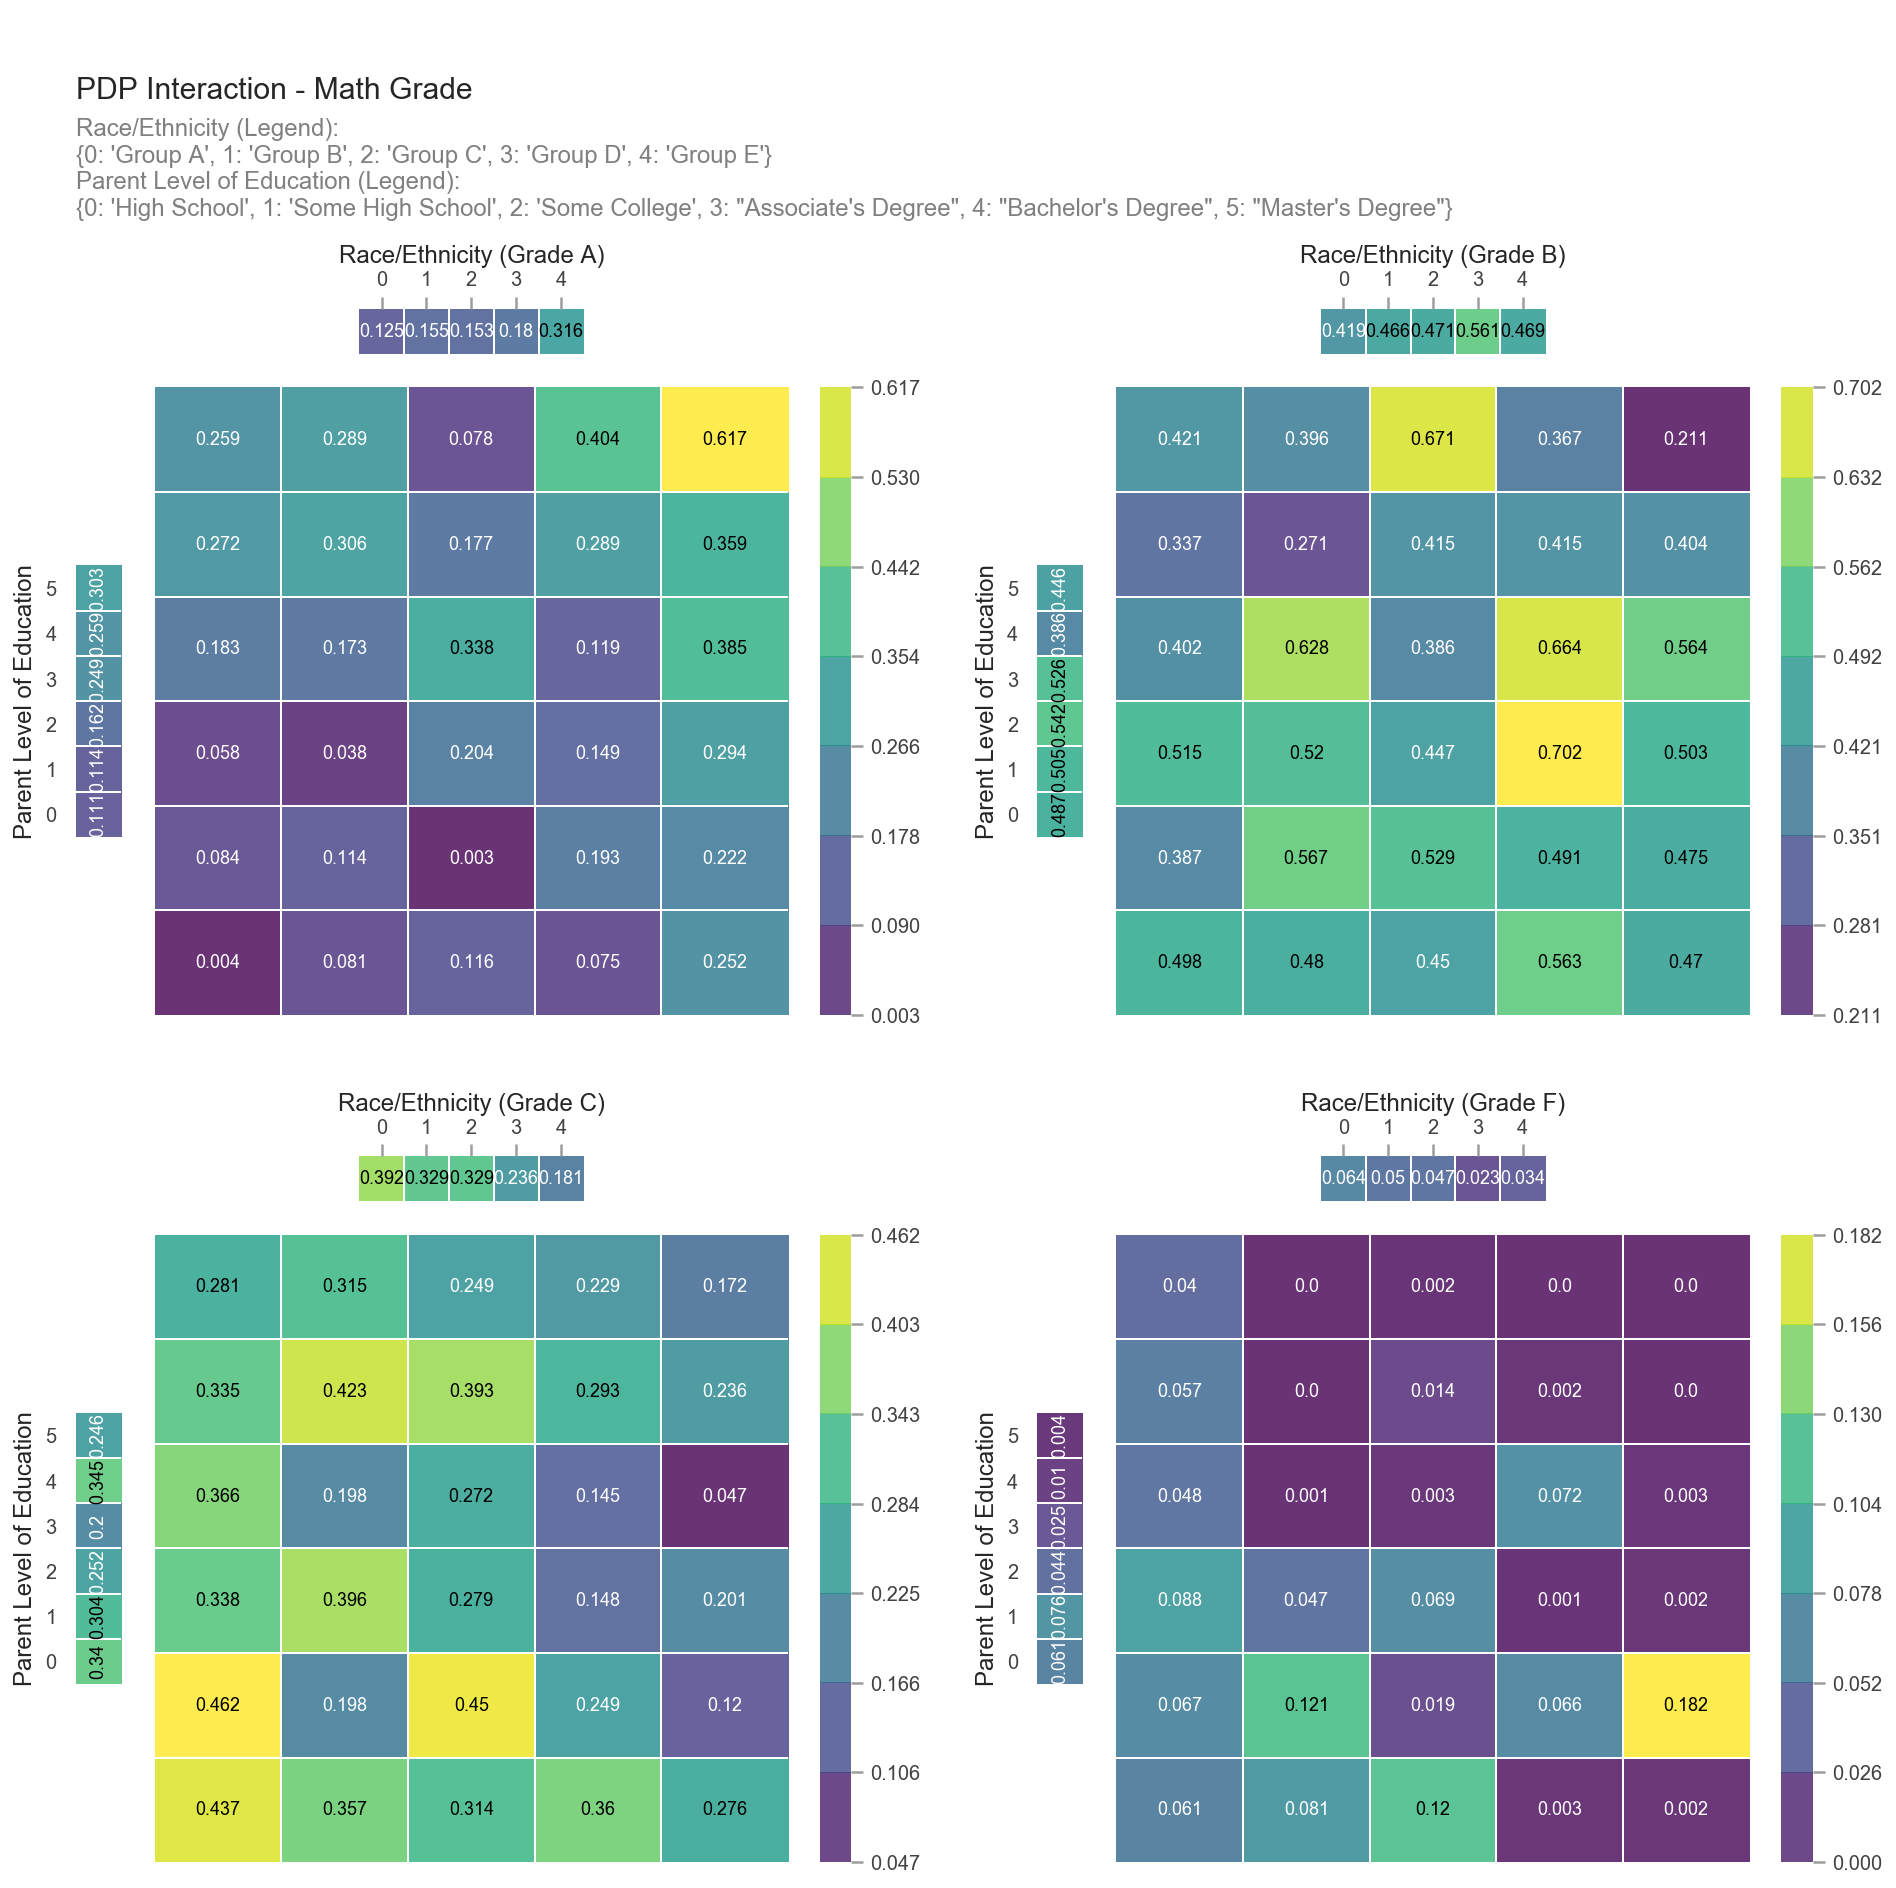

In [49]:
pdp_race_parent = pdp.pdp_interact(model=math_model,
                                   dataset=df,
                                   model_features=feature_cols,
                                   features=['race_le', 'parent_le'])
plot_params = {
    # plot title and subtitle
    'title': 'PDP Interaction - Math Grade',
    'subtitle': 'Race/Ethnicity (Legend): \n%s\nParent Level of Education (Legend): \n%s' % (race_title, parent_title),
    'title_fontsize': 15,
    'subtitle_fontsize': 12,
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 0.8,
    # fontsize for interact plot text
    'inter_fontsize': 9,
}
fig, axes = pdp.pdp_interact_plot(pdp_race_parent, ['Race/Ethnicity', 'Parent Level of Education'],
                                  plot_type='grid', plot_pdp=True, plot_params=plot_params)
axes['pdp_inter_ax'][0]['_pdp_x_ax'].set_xlabel('Race/Ethnicity (Grade A)')
axes['pdp_inter_ax'][1]['_pdp_x_ax'].set_xlabel('Race/Ethnicity (Grade B)')
axes['pdp_inter_ax'][2]['_pdp_x_ax'].set_xlabel('Race/Ethnicity (Grade C)')
axes['pdp_inter_ax'][3]['_pdp_x_ax'].set_xlabel('Race/Ethnicity (Grade F)')
axes['pdp_inter_ax'][0]['_pdp_inter_ax'].grid(False)
axes['pdp_inter_ax'][0]['_pdp_x_ax'].grid(False)
axes['pdp_inter_ax'][0]['_pdp_y_ax'].grid(False)
axes['pdp_inter_ax'][1]['_pdp_inter_ax'].grid(False)
axes['pdp_inter_ax'][1]['_pdp_x_ax'].grid(False)
axes['pdp_inter_ax'][1]['_pdp_y_ax'].grid(False)
axes['pdp_inter_ax'][2]['_pdp_inter_ax'].grid(False)
axes['pdp_inter_ax'][2]['_pdp_x_ax'].grid(False)
axes['pdp_inter_ax'][2]['_pdp_y_ax'].grid(False)
axes['pdp_inter_ax'][3]['_pdp_inter_ax'].grid(False)
axes['pdp_inter_ax'][3]['_pdp_x_ax'].grid(False)
axes['pdp_inter_ax'][3]['_pdp_y_ax'].grid(False)
fig.savefig('images/chapter_03_pdp_interaction_race_parent_math.png', dpi=300, bbox_inches='tight');
fig.savefig('images/chapter_03_pdp_interaction_race_parent_math.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [50]:
df_gpA = df[df['race/ethnicity'] == 'group A'].reset_index()
df_gpC = df[df['race/ethnicity'] == 'group C'].reset_index()

In [51]:
def plot_vc_bar_charts(df, df_gpA, df_gpC, col):
    def vc(df, col):
        df_vc = df[col].value_counts() / len(df) * 100
        df_vc = df_vc.reset_index()
        df_vc = df_vc.rename(columns={'index': col, col: 'pc'})
        return df_vc
    df_vc = vc(df, col)
    df_gpA_vc = vc(df_gpA, col)
    df_gpC_vc = vc(df_gpC, col)
    
    bar_width = 0.35
    opacity = 0.9
    labels = df_vc[col].values
    capitalized_labels = []
    for label in labels:
        words = label.split(' ')
        capitalized_label = ' '.join([w.capitalize() for w in words])
        capitalized_labels.append(capitalized_label)
    sizes = df_vc['pc'].values
    sizes_a = df_gpA_vc[]
    index = np.arange(len(sizes))
    
    fig, ax = plt.subplots()
    index = np.arange(len(feature_names))
    bar_width = 0.2
    opacity = 0.9
    error_config = {'ecolor': '0.3'}
    ax.bar(index, math_fi, bar_width,
           alpha=opacity, color='r',
           label='Math Grade Model')
    ax.bar(index + bar_width, reading_fi, bar_width,
           alpha=opacity, color='g',
           label='Reading Grade Model')
    ax.bar(index + bar_width * 2, writing_fi, bar_width,
           alpha=opacity, color='b',
           label='Writing Grade Model')   
    ax.set_xlabel('')
    ax.set_ylabel('Feature Importance (%)')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(feature_names)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True);

    ax.bar(index, sizes, bar_width,
           alpha=opacity,
           label=labels,
           color=color)
    ax.set_xticks(index)
    ax.set_xticklabels(capitalized_labels)
    ax.grid(True);

SyntaxError: invalid syntax (<ipython-input-51-29bdce7a6d94>, line 20)

In [54]:
import scipy.stats as ss
def cramers_corrected_stat(confusion_matrix):
    """ Calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [55]:
def get_ple_pcs(df):
    levels = ['high school', 'some high school', 'some college', 'associate\'s degree', 'bachelor\'s degree',
              'master\'s degree']
    df_ple = df.groupby('parental level of education').agg({'lunch': 'count'}).reset_index()
    pcs = []
    for level in levels:
        pc = df_ple[df_ple['parental level of education'] == level]['lunch'].values[0] / len(df) * 100
        pcs.append(pc)
    return levels, pcs
levels, pcs = get_ple_pcs(df)
_, pcs_gpA = get_ple_pcs(df_gpA)
_, pcs_gpC = get_ple_pcs(df_gpC)

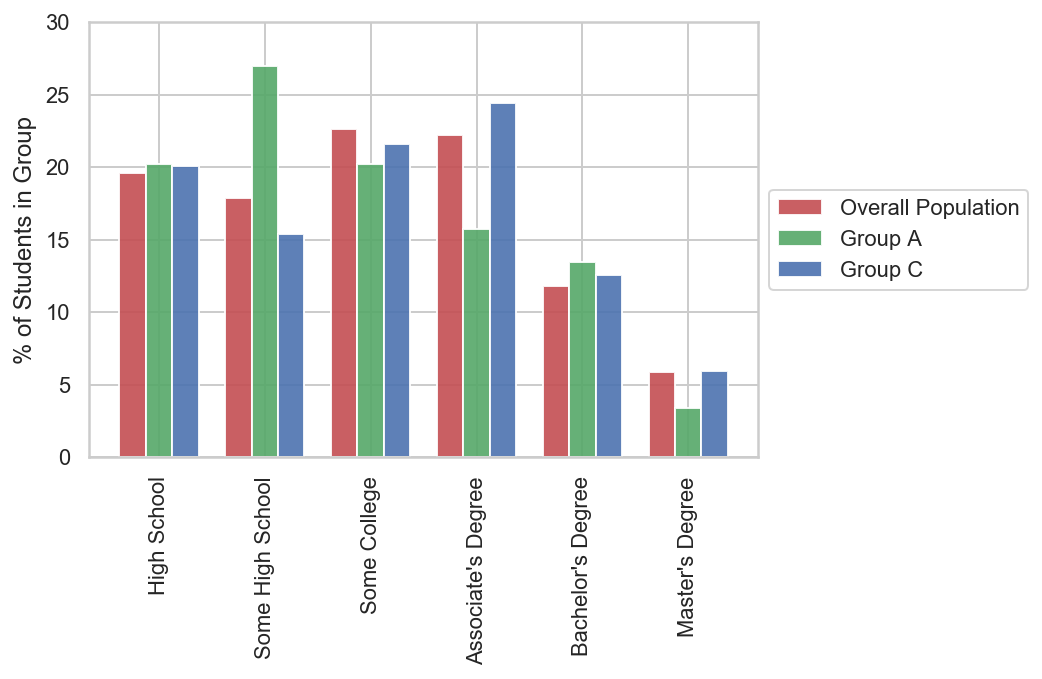

In [56]:
fig, ax = plt.subplots()
index = np.arange(len(levels))
capitalized_labels = []
for label in levels:
    words = label.split(' ')
    capitalized_label = ' '.join([w.capitalize() for w in words])
    capitalized_labels.append(capitalized_label)
bar_width = 0.25
opacity = 0.9
error_config = {'ecolor': '0.3'}
ax.bar(index, pcs, bar_width,
       alpha=opacity, color='r',
       label='Overall Population')
ax.bar(index + bar_width, pcs_gpA, bar_width,
       alpha=opacity, color='g',
       label='Group A')
ax.bar(index + bar_width * 2, pcs_gpC, bar_width,
       alpha=opacity, color='b',
       label='Group C')   
ax.set_xlabel('')
ax.set_ylabel('% of Students in Group')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(capitalized_labels)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True);
ax.set_ylim([0, 30]);
fig.savefig('images/chapter_03_ple_dist_overall_gpa_gpc.png', dpi=300, bbox_inches='tight');
fig.savefig('images/chapter_03_ple_dist_overall_gpa_gpc.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [57]:
confusion_matrix = pd.crosstab(df['parental level of education'], 
                               df['race/ethnicity'])
cramers_corrected_stat(confusion_matrix)

0.04867387848351325

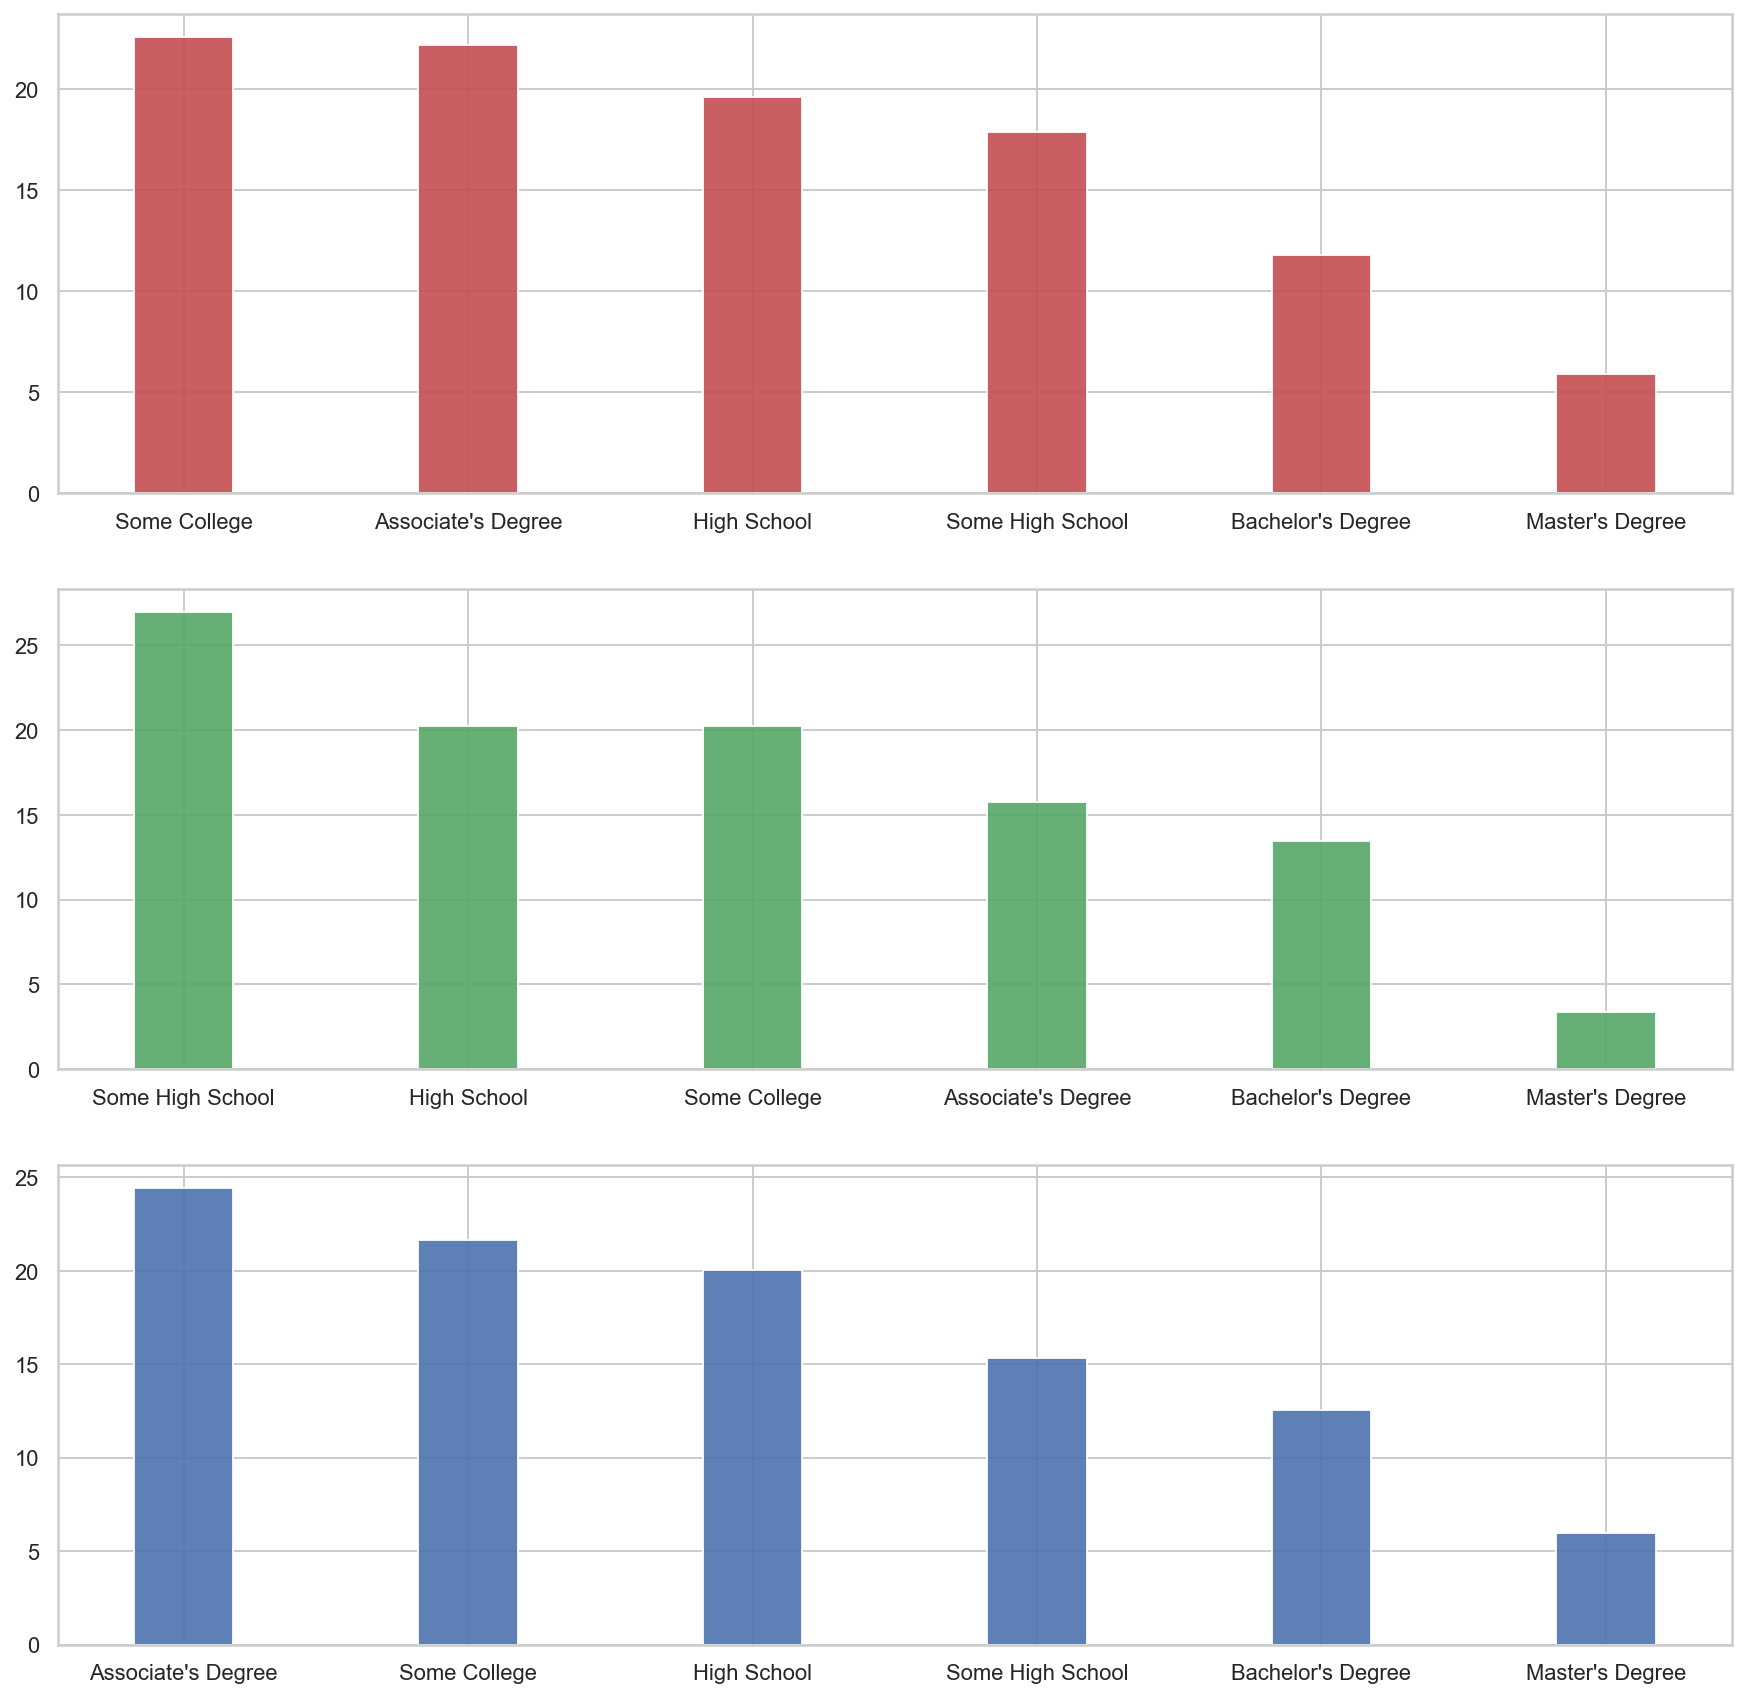

In [58]:
f, ax = plt.subplots(3, 1, figsize=(15, 15))
plot_vc_bar_charts(df, 'parental level of education', ax[0], 'r')
plot_vc_bar_charts(df_gpA, 'parental level of education', ax[1], 'g')
plot_vc_bar_charts(df_gpC, 'parental level of education', ax[2], 'b')